In [1]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon, Point
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
# import dill
import geopandas
import geopandas as gpd
import matplotlib.colors as colors
import wandb
from typing import Optional, Union
from pathlib import Path
import orbax.checkpoint
import dill
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error


# JAX
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'gpu')  # Use GPU

from jax import random, lax, jit, ops
from jax.example_libraries import stax
# previously was "from jax.experimental import stax" due to previous versions of jax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim
import random as rnd

# check versions
print(numpyro.__version__)
print(jax.__version__)
# print(torch.__version__)
from platform import python_version
print(python_version())

0.14.0
0.4.30
3.12.3


## Admin type

In [2]:
# Set admin level
admin_level = 2

## Read shape files

In [3]:
shape_new = gpd.read_file(f"data/Shapefiles/zmb_admbnda_adm{admin_level}_dmmu_20201124.shp")
shape_new = shape_new[[f"ADM{admin_level}_EN", 'geometry']]
shape_new['new'] = 1
shape_new

ADM2_EN                                           geometry  new
0         Chibombo  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...    1
1         Chisamba  POLYGON ((28.65022 -14.38920, 28.65131 -14.389...    1
2         Chitambo  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1
3     Itezhi-tezhi  POLYGON ((26.99044 -15.46178, 27.20284 -15.468...    1
4            Kabwe  POLYGON ((28.33593 -14.26089, 28.33684 -14.262...    1
..             ...                                                ...  ...
110          Sioma  POLYGON ((23.22303 -16.24968, 23.22304 -16.249...    1
111  Kapiri Mposhi  POLYGON ((28.97528 -13.77728, 28.97804 -13.777...    1
112      Nchelenge  POLYGON ((28.98384 -9.11358, 29.01004 -9.12788...    1
113   Shiwamg'andu  POLYGON ((31.71596 -10.50328, 31.72146 -10.507...    1
114      Mporokoso  POLYGON ((29.88054 -9.21468, 29.88514 -9.21548...    1

[115 rows x 3 columns]

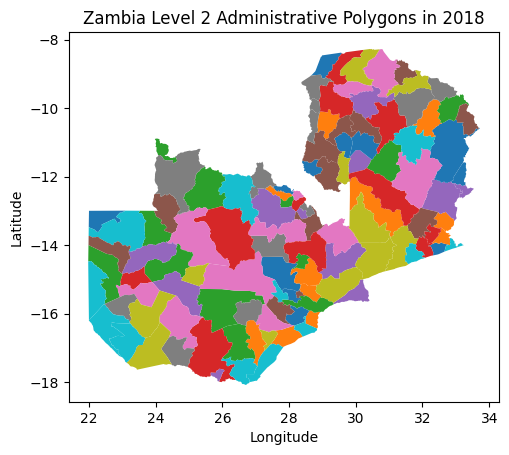

In [4]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
shape_new.plot(ax=ax, column=f"ADM{admin_level}_EN")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Zambia Level {admin_level} Administrative Polygons in 2018')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_polygons.pdf')

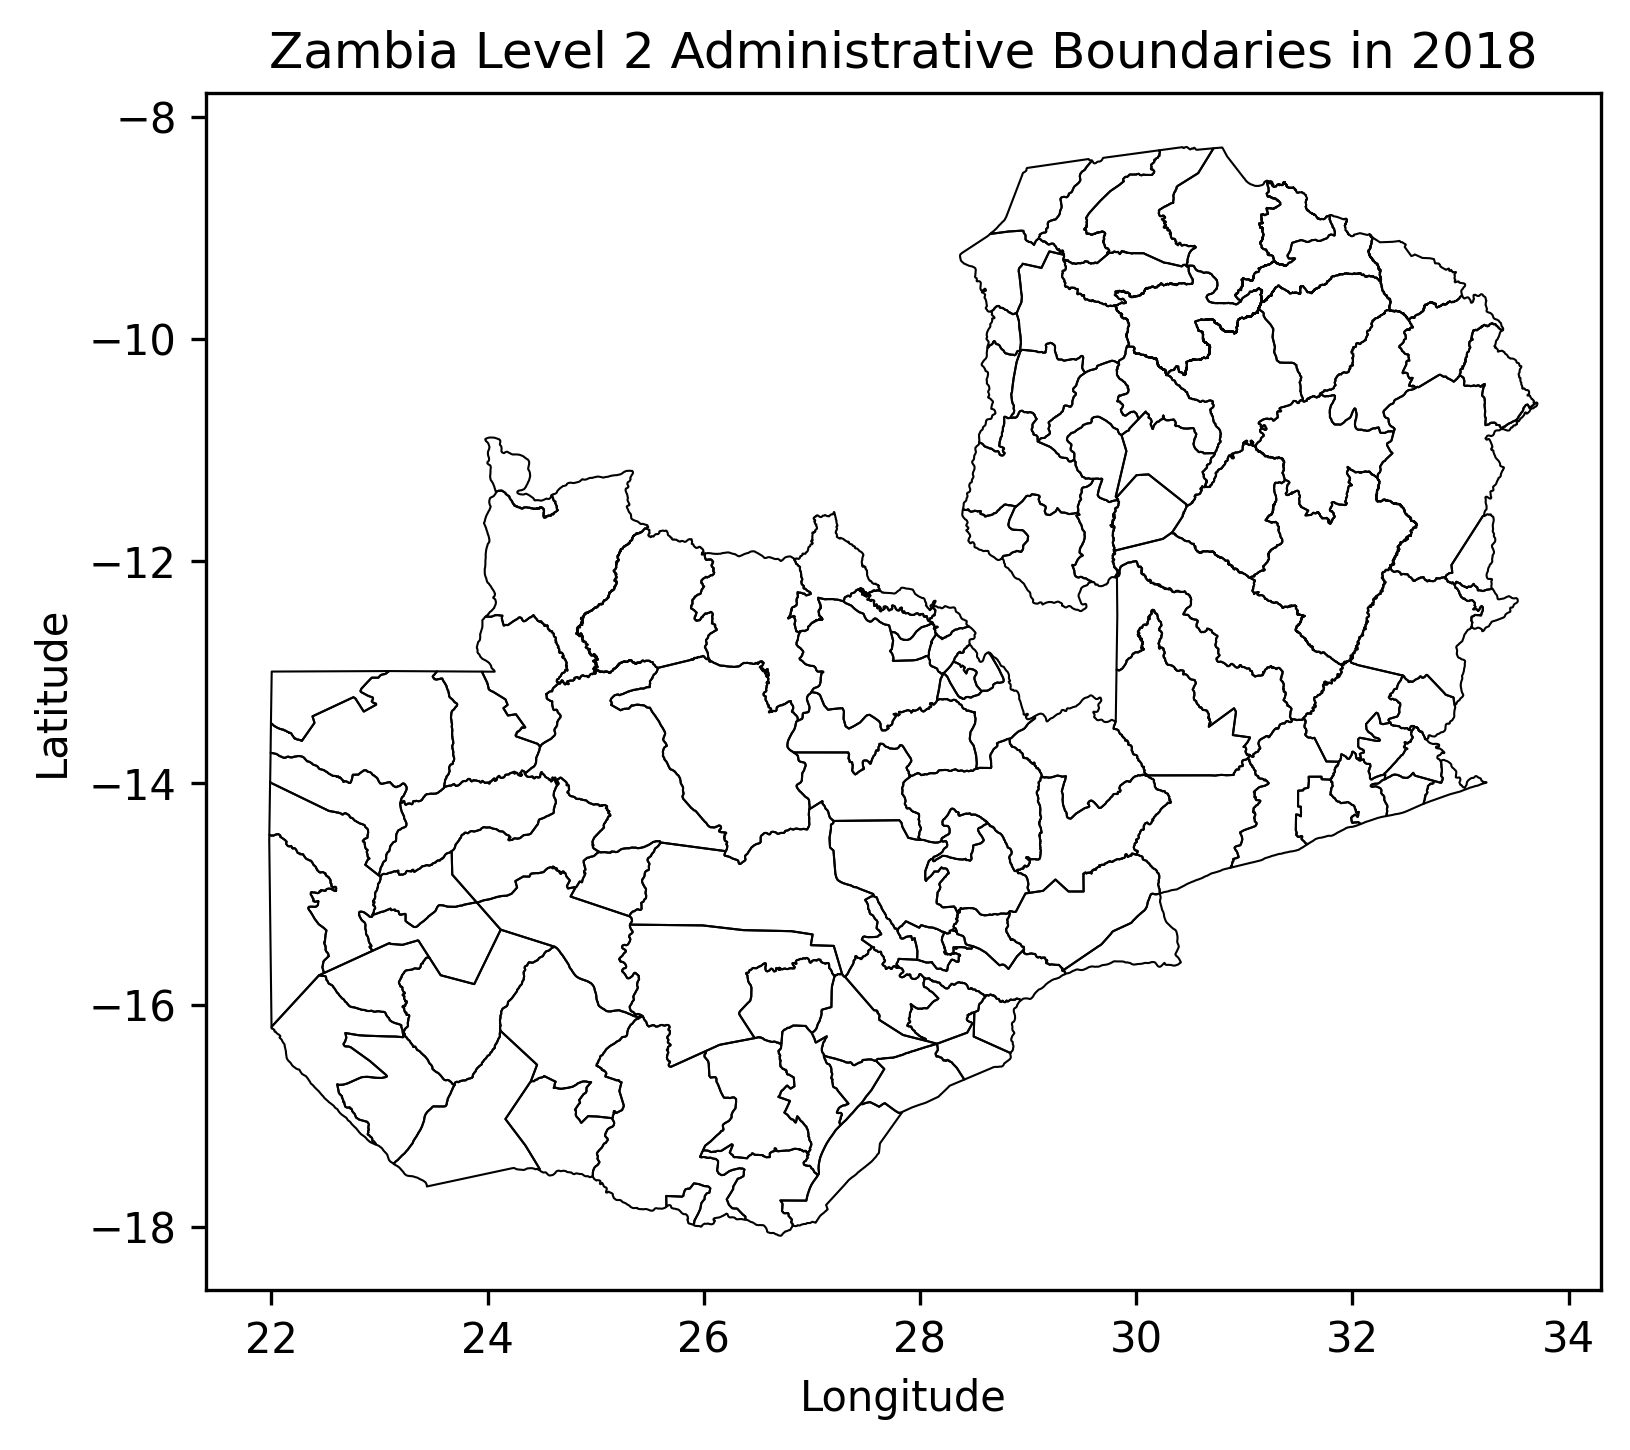

In [5]:
shape_new.boundary.plot(linewidth=0.5,  edgecolor='black', figsize=(6,6))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Zambia Level {admin_level} Administrative Boundaries in 2018')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_boundaries.pdf')

In [6]:
# capitalise unit names
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
shape_new[f"ADM{admin_level}_EN"] =  np.array([names_shape_new[i].upper() for i in range(len(names_shape_new))])
shape_new.head(5)

ADM2_EN                                           geometry  new
0      CHIBOMBO  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...    1
1      CHISAMBA  POLYGON ((28.65022 -14.38920, 28.65131 -14.389...    1
2      CHITAMBO  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1
3  ITEZHI-TEZHI  POLYGON ((26.99044 -15.46178, 27.20284 -15.468...    1
4         KABWE  POLYGON ((28.33593 -14.26089, 28.33684 -14.262...    1

In [7]:
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
names_shape_new

array(['CHIBOMBO', 'CHISAMBA', 'CHITAMBO', 'ITEZHI-TEZHI', 'KABWE',
       'LUANO', 'MKUSHI', 'MUMBWA', 'NGABWE', 'SERENJE', 'CHILILABOMBWE',
       'CHINGOLA', 'KALULUSHI', 'KITWE', 'LUANSHYA', 'LUFWANYAMA',
       'MASAITI', 'MPONGWE', 'MUFULIRA', 'NDOLA', 'CHADIZA', 'CHASEFU',
       'CHIPANGALI', 'CHIPATA', 'KASENENGWA', 'KATETE', 'LUMEZI',
       'LUNDAZI', 'MAMBWE', 'NYIMBA', 'PETAUKE', 'SINDA', 'VUBWI',
       'CHEMBE', 'CHIENGI', 'CHIFUNABULI', 'CHIPILI', 'KAWAMBWA', 'LUNGA',
       'MANSA', 'MILENGI', 'MWANSABOMBWE', 'MWENSE', 'SAMFYA', 'CHILANGA',
       'CHIRUNDU', 'CHONGWE', 'KAFUE', 'LUANGWA', 'LUSAKA', 'RUFUNSA',
       'SHIBUYUNJI', 'CHAMA', 'CHINSALI', 'ISOKA', 'KANCHIBIYA',
       'LAVUSHIMANDA', 'MAFINGA', 'MPIKA', 'NAKONDE', 'CHAVUMA',
       'IKELENGE', 'KABOMPO', 'KALUMBILA', 'KASEMPA', 'MANYINGA',
       'MUFUMBWE', 'MUSHINDANO', 'MWINILUNGA', 'SOLWEZI', 'ZAMBEZI',
       'CHILUBI', 'KAPUTA', 'KASAMA', 'LUNTE DISTRICT', 'LUPOSOSHI',
       'LUWINGU', 'MBALA', 'MPU

# Malaria data

In [8]:
infections_new = pd.read_csv(f"../../data/dhs/ZMB_prev_data_admin{admin_level}.csv")
infections_new = infections_new[['unit', 'usage', 'num_rdt', 'num_rdt_positive', 'prev_estimate']]
infections_new = infections_new.rename({'unit': 'area'}, axis='columns')
infections_new = infections_new.sort_values(by=['area'])
infections_new.head(5)

area     usage     num_rdt  num_rdt_positive  prev_estimate
0  Chadiza  0.592593   43.522101          2.352546       0.054054
1    Chama  0.656690  219.745559         13.109616       0.059658
2  Chasefu  0.491268  157.033307          2.872475       0.018292
3  Chavuma  0.438596   56.444920          5.039725       0.089286
4   Chembe  0.826087   50.954995          0.000000       0.000000

## Merge infections and shape

In [9]:
if (admin_level==2):
    # Create new rows with zero values
    new_rows = pd.DataFrame({'area': ['CHIRUNDU', 'ITEZHI-TEZHI', 'SHIBUYUNJI'],
                             'usage': [0.0, 0.0, 0.0],
                             'num_rdt': [0.0, 0.0, 0.0],
                             'num_rdt_positive': [0.0, 0.0, 0.0],
                             'prev_estimate': [0.0, 0.0, 0.0]})

    # Append new rows to infections_new
    infections_new = pd.concat([infections_new, new_rows])

In [10]:
names_infections_new = infections_new.area.values
shape_new = shape_new.rename({f"ADM{admin_level}_EN": 'area'}, axis='columns')
shape_new = shape_new.sort_values(by=['area'])
shape_new.head(3)
names_shape_new = shape_new['area'].values
print(names_infections_new)
print(names_shape_new)

['Chadiza' 'Chama' 'Chasefu' 'Chavuma' 'Chembe' 'Chibombo' 'Chiengi'
 'Chifunabuli' 'Chikankanta' 'Chilanga' 'Chililabombwe' 'Chilubi'
 'Chingola' 'Chinsali' 'Chipangali' 'Chipata' 'Chipili' 'Chisamba'
 'Chitambo' 'Choma' 'Chongwe' 'Gwembe' 'Ikelenge' 'Isoka' 'Kabompo'
 'Kabwe' 'Kafue' 'Kalabo' 'Kalomo' 'Kalulushi' 'Kalumbila' 'Kanchibiya'
 'Kaoma' 'Kapiri Mposhi' 'Kaputa' 'Kasama' 'Kasempa' 'Kasenengwa' 'Katete'
 'Kawambwa' 'Kazungula' 'Kitwe' 'Lavushimanda' 'Limulunga' 'Livingstone'
 'Luampa' 'Luangwa' 'Luano' 'Luanshya' 'Lufwanyama' 'Lukulu' 'Lumezi'
 'Lundazi' 'Lunga' 'Lunte District' 'Lupososhi' 'Lusaka' 'Luwingu'
 'Mafinga' 'Mambwe' 'Mansa' 'Manyinga' 'Masaiti' 'Mazabuka' 'Mbala'
 'Milengi' 'Mitete' 'Mkushi' 'Mongu' 'Monze' 'Mpika' 'Mpongwe' 'Mporokoso'
 'Mpulungu' 'Mufulira' 'Mufumbwe' 'Mulobezi' 'Mumbwa' 'Mungwi'
 'Mushindano' 'Mwandi' 'Mwansabombwe' 'Mwense' 'Mwinilunga' 'Nakonde'
 'Nalolo' 'Namwala' 'Nchelenge' 'Ndola' 'Ngabwe' 'Nkeyema' 'Nsama'
 'Nyimba' 'Pemba' 'Petauke' 'R

In [11]:
# Re-labelling for admin level 1
if (admin_level==1):
    names_infections_new[6] = 'North-Western'
# convert to uppercase
names_infections_new = [names_infections_new[i].upper() for i in range(len(names_infections_new))]
print(names_infections_new)
print(names_shape_new)

['CHADIZA', 'CHAMA', 'CHASEFU', 'CHAVUMA', 'CHEMBE', 'CHIBOMBO', 'CHIENGI', 'CHIFUNABULI', 'CHIKANKANTA', 'CHILANGA', 'CHILILABOMBWE', 'CHILUBI', 'CHINGOLA', 'CHINSALI', 'CHIPANGALI', 'CHIPATA', 'CHIPILI', 'CHISAMBA', 'CHITAMBO', 'CHOMA', 'CHONGWE', 'GWEMBE', 'IKELENGE', 'ISOKA', 'KABOMPO', 'KABWE', 'KAFUE', 'KALABO', 'KALOMO', 'KALULUSHI', 'KALUMBILA', 'KANCHIBIYA', 'KAOMA', 'KAPIRI MPOSHI', 'KAPUTA', 'KASAMA', 'KASEMPA', 'KASENENGWA', 'KATETE', 'KAWAMBWA', 'KAZUNGULA', 'KITWE', 'LAVUSHIMANDA', 'LIMULUNGA', 'LIVINGSTONE', 'LUAMPA', 'LUANGWA', 'LUANO', 'LUANSHYA', 'LUFWANYAMA', 'LUKULU', 'LUMEZI', 'LUNDAZI', 'LUNGA', 'LUNTE DISTRICT', 'LUPOSOSHI', 'LUSAKA', 'LUWINGU', 'MAFINGA', 'MAMBWE', 'MANSA', 'MANYINGA', 'MASAITI', 'MAZABUKA', 'MBALA', 'MILENGI', 'MITETE', 'MKUSHI', 'MONGU', 'MONZE', 'MPIKA', 'MPONGWE', 'MPOROKOSO', 'MPULUNGU', 'MUFULIRA', 'MUFUMBWE', 'MULOBEZI', 'MUMBWA', 'MUNGWI', 'MUSHINDANO', 'MWANDI', 'MWANSABOMBWE', 'MWENSE', 'MWINILUNGA', 'NAKONDE', 'NALOLO', 'NAMWALA', 'NC

In [12]:
names_shape_new_lst = list(names_shape_new)
lst = [names_shape_new_lst[i] not in names_infections_new for i in range(len(names_shape_new))]
[names_shape_new_lst[i] for i in range(len(lst)) if lst[i] == True]

[]

In [13]:
names_infections_lst = list(names_infections_new)
lst2 = [names_infections_lst[i] not in names_shape_new for i in range(len(names_infections_new))]
[names_infections_lst[i] for i in range(len(lst2)) if lst2[i] == True]

[]

In [14]:
names_infections_new

['CHADIZA',
 'CHAMA',
 'CHASEFU',
 'CHAVUMA',
 'CHEMBE',
 'CHIBOMBO',
 'CHIENGI',
 'CHIFUNABULI',
 'CHIKANKANTA',
 'CHILANGA',
 'CHILILABOMBWE',
 'CHILUBI',
 'CHINGOLA',
 'CHINSALI',
 'CHIPANGALI',
 'CHIPATA',
 'CHIPILI',
 'CHISAMBA',
 'CHITAMBO',
 'CHOMA',
 'CHONGWE',
 'GWEMBE',
 'IKELENGE',
 'ISOKA',
 'KABOMPO',
 'KABWE',
 'KAFUE',
 'KALABO',
 'KALOMO',
 'KALULUSHI',
 'KALUMBILA',
 'KANCHIBIYA',
 'KAOMA',
 'KAPIRI MPOSHI',
 'KAPUTA',
 'KASAMA',
 'KASEMPA',
 'KASENENGWA',
 'KATETE',
 'KAWAMBWA',
 'KAZUNGULA',
 'KITWE',
 'LAVUSHIMANDA',
 'LIMULUNGA',
 'LIVINGSTONE',
 'LUAMPA',
 'LUANGWA',
 'LUANO',
 'LUANSHYA',
 'LUFWANYAMA',
 'LUKULU',
 'LUMEZI',
 'LUNDAZI',
 'LUNGA',
 'LUNTE DISTRICT',
 'LUPOSOSHI',
 'LUSAKA',
 'LUWINGU',
 'MAFINGA',
 'MAMBWE',
 'MANSA',
 'MANYINGA',
 'MASAITI',
 'MAZABUKA',
 'MBALA',
 'MILENGI',
 'MITETE',
 'MKUSHI',
 'MONGU',
 'MONZE',
 'MPIKA',
 'MPONGWE',
 'MPOROKOSO',
 'MPULUNGU',
 'MUFULIRA',
 'MUFUMBWE',
 'MULOBEZI',
 'MUMBWA',
 'MUNGWI',
 'MUSHINDANO',
 'MWAN

In [15]:
infections_new.area = names_infections_new
infections_new

area     usage     num_rdt  num_rdt_positive  prev_estimate
0         CHADIZA  0.592593   43.522101          2.352546       0.054054
1           CHAMA  0.656690  219.745559         13.109616       0.059658
2         CHASEFU  0.491268  157.033307          2.872475       0.018292
3         CHAVUMA  0.438596   56.444920          5.039725       0.089286
4          CHEMBE  0.826087   50.954995          0.000000       0.000000
..            ...       ...         ...               ...            ...
110       ZAMBEZI  0.729241  121.081102          1.686360       0.013928
111         ZIMBA  0.542139   89.358756          9.592446       0.107348
0        CHIRUNDU  0.000000    0.000000          0.000000       0.000000
1    ITEZHI-TEZHI  0.000000    0.000000          0.000000       0.000000
2      SHIBUYUNJI  0.000000    0.000000          0.000000       0.000000

[115 rows x 5 columns]

In [16]:
shape_new = shape_new.merge(infections_new, how='left', left_on='area', right_on='area')
shape_new.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   

      num_rdt  num_rdt_positive  prev_estimate  
0   43.522101          2.352546       0.054054  
1  219.745559         13.109616       0.059658  
2  157.033307          2.872475       0.018292

In [17]:
np.sum(np.isnan(shape_new.num_rdt))

0

In [18]:
s_new = shape_new.rename({'num_rdt': 'n_obs', 'num_rdt_positive': 'y', 'prev_estimate': 'estimate'}, axis='columns')
s_new['y'] = round(s_new['y']).astype(int)
s_new['n_obs'] = round(s_new['n_obs']).astype(int)
s_new.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292

In [19]:
s_new_plot = shape_new.rename({'num_rdt': 'Total observations', 'num_rdt_positive': 'Positive test count', 'prev_estimate': 'Prevalence estimate'}, axis='columns')

In [20]:
s_new_plot

area                                           geometry  new  \
0    CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1   
1      CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1   
2    CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1   
3    CHAVUMA  POLYGON ((21.99573 -13.46393, 21.99610 -13.439...    1   
4     CHEMBE  POLYGON ((28.89259 -11.50817, 28.87754 -11.520...    1   
..       ...                                                ...  ...   
110    SIOMA  POLYGON ((23.22303 -16.24968, 23.22304 -16.249...    1   
111  SOLWEZI  POLYGON ((26.54644 -11.95768, 26.55784 -11.971...    1   
112    VUBWI  POLYGON ((32.93181 -13.86676, 32.94124 -13.874...    1   
113  ZAMBEZI  POLYGON ((23.51068 -13.06689, 23.52472 -13.068...    1   
114    ZIMBA  POLYGON ((26.26911 -17.26109, 26.24051 -17.329...    1   

        usage  Total observations  Positive test count  Prevalence estimate  
0    0.592593           43.522101             2.352546             0.054054  
1    0.656690          219.745559            13.109616             0.059658  
2    0.491268          157.033307             2.872475             0.018292  
3    0.438596           56.444920             5.039725             0.089286  
4    0.826087           50.954995             0.000000             0.000000  
..        ...                 ...                  ...                  ...  
110  0.740689           47.863205             5.892910             0.123120  
111  0.428974          407.405644            17.259948             0.042366  
112  0.620205          120.844356             3.945904             0.032653  
113  0.729241          121.081102             1.686360             0.013928  
114  0.542139           89.358756             9.592446             0.107348  

[115 rows x 7 columns]

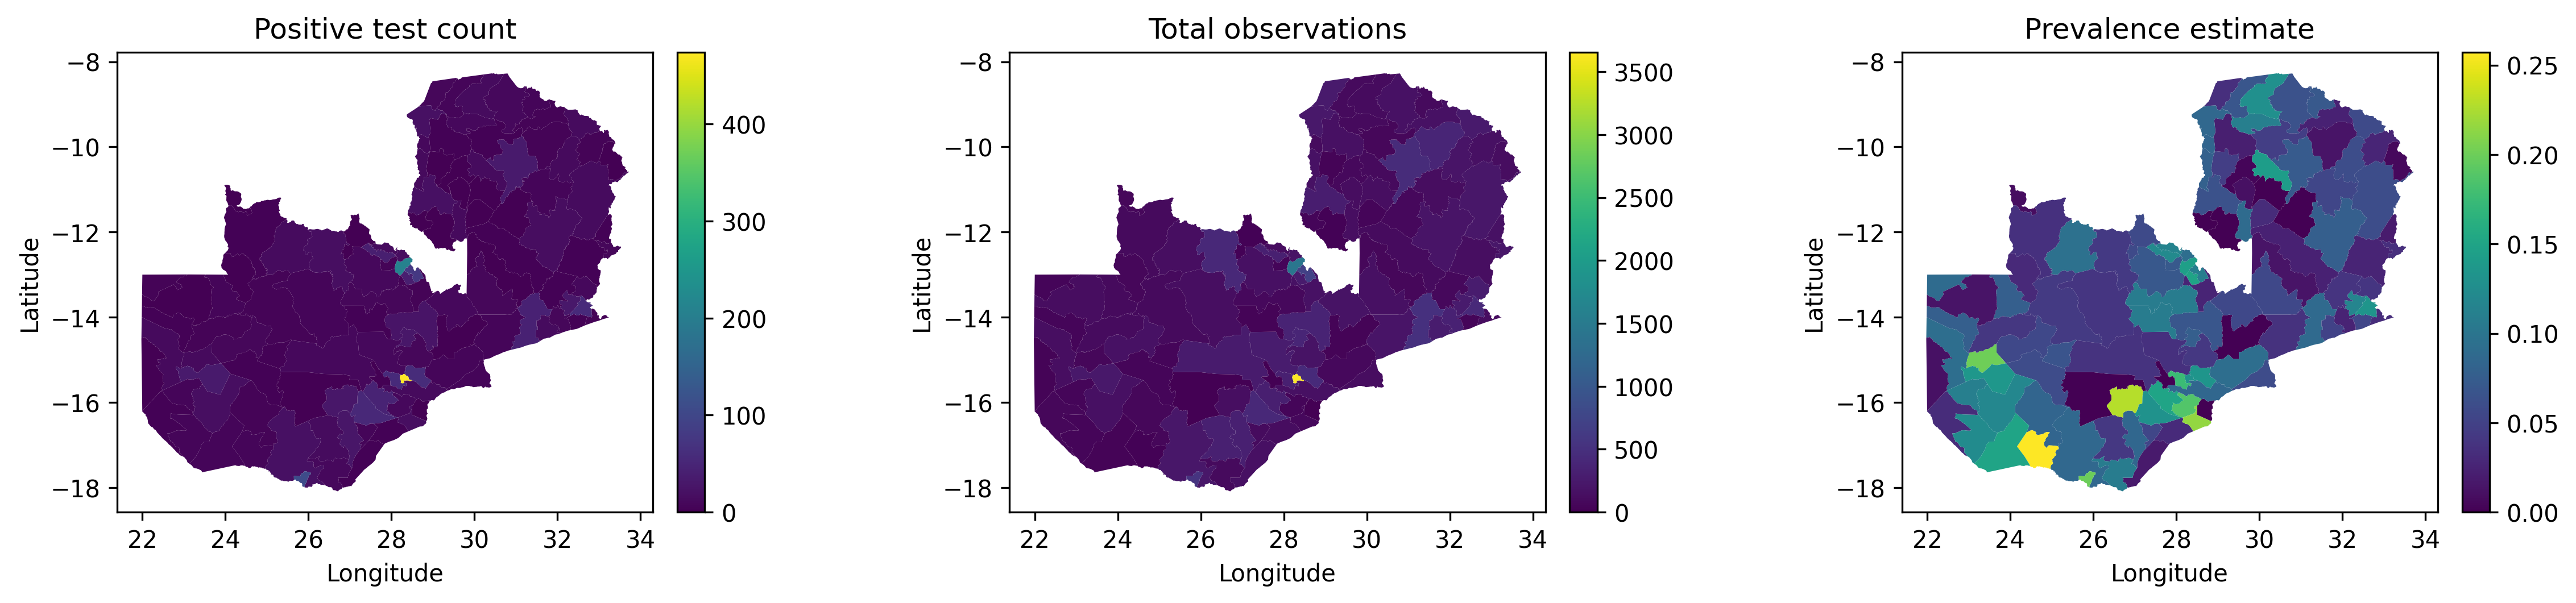

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot the data with a consistent colorbar size
for i, column in enumerate(["Positive test count", "Total observations", "Prevalence estimate"]):
    plot = s_new_plot.plot(column=column, ax=ax[i], legend=False)
    ax[i].set_title(column)
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Latitude')
    
    # Create an axis on the right side of the plot for the colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Create colorbar using the first collection's norm and cmap
    sm = plt.cm.ScalarMappable(cmap=plot.collections[0].cmap, norm=plot.collections[0].norm)
    sm._A = []  # Dummy array for the scalar mappable
    fig.colorbar(sm, cax=cax)

# Adjust space between plots
plt.subplots_adjust(wspace=0.5)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Save the figure as a PDF
plt.savefig(f'figures/ZMB2018_{admin_level}_observations.pdf')

In [22]:
if (admin_level==2):
    # Check y and n_obs for capital, Lusaka
    lusaka_data = s_new[s_new['area'] == 'LUSAKA']
    print(lusaka_data[['y', 'n_obs']])

      y  n_obs
58  474   3653


In [23]:
del shape_new
del infections_new

## Computational grid

In [24]:
x_min, x_max, y_min, y_max = 21.5, 34, -19, -8
dy = y_max - y_min
dx = x_max - x_min
factor = dy / dx
n_x = 40 
n_y = math.ceil(n_x * factor)
print(n_x)
print(n_y)
print(n_x * n_y)

x_grid = np.linspace(x_min, x_max, n_x, endpoint=True)
y_grid = np.linspace(y_min, y_max, n_y, endpoint=True)

# full coordinate arrays
x_coords, y_coords = np.meshgrid(x_grid, y_grid)
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

df = pd.DataFrame({'Latitude': y_coords, 'Longitude': x_coords})

grid_pts = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

x = jnp.array([x_coords, y_coords]).transpose((1, 0))
print(x.shape)

40
36
1440
(1440, 2)


2024-08-08 11:27:53.562460: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [25]:
xtest = np.tile(x, (12, 1, 1))
xtest.shape

(12, 1440, 2)

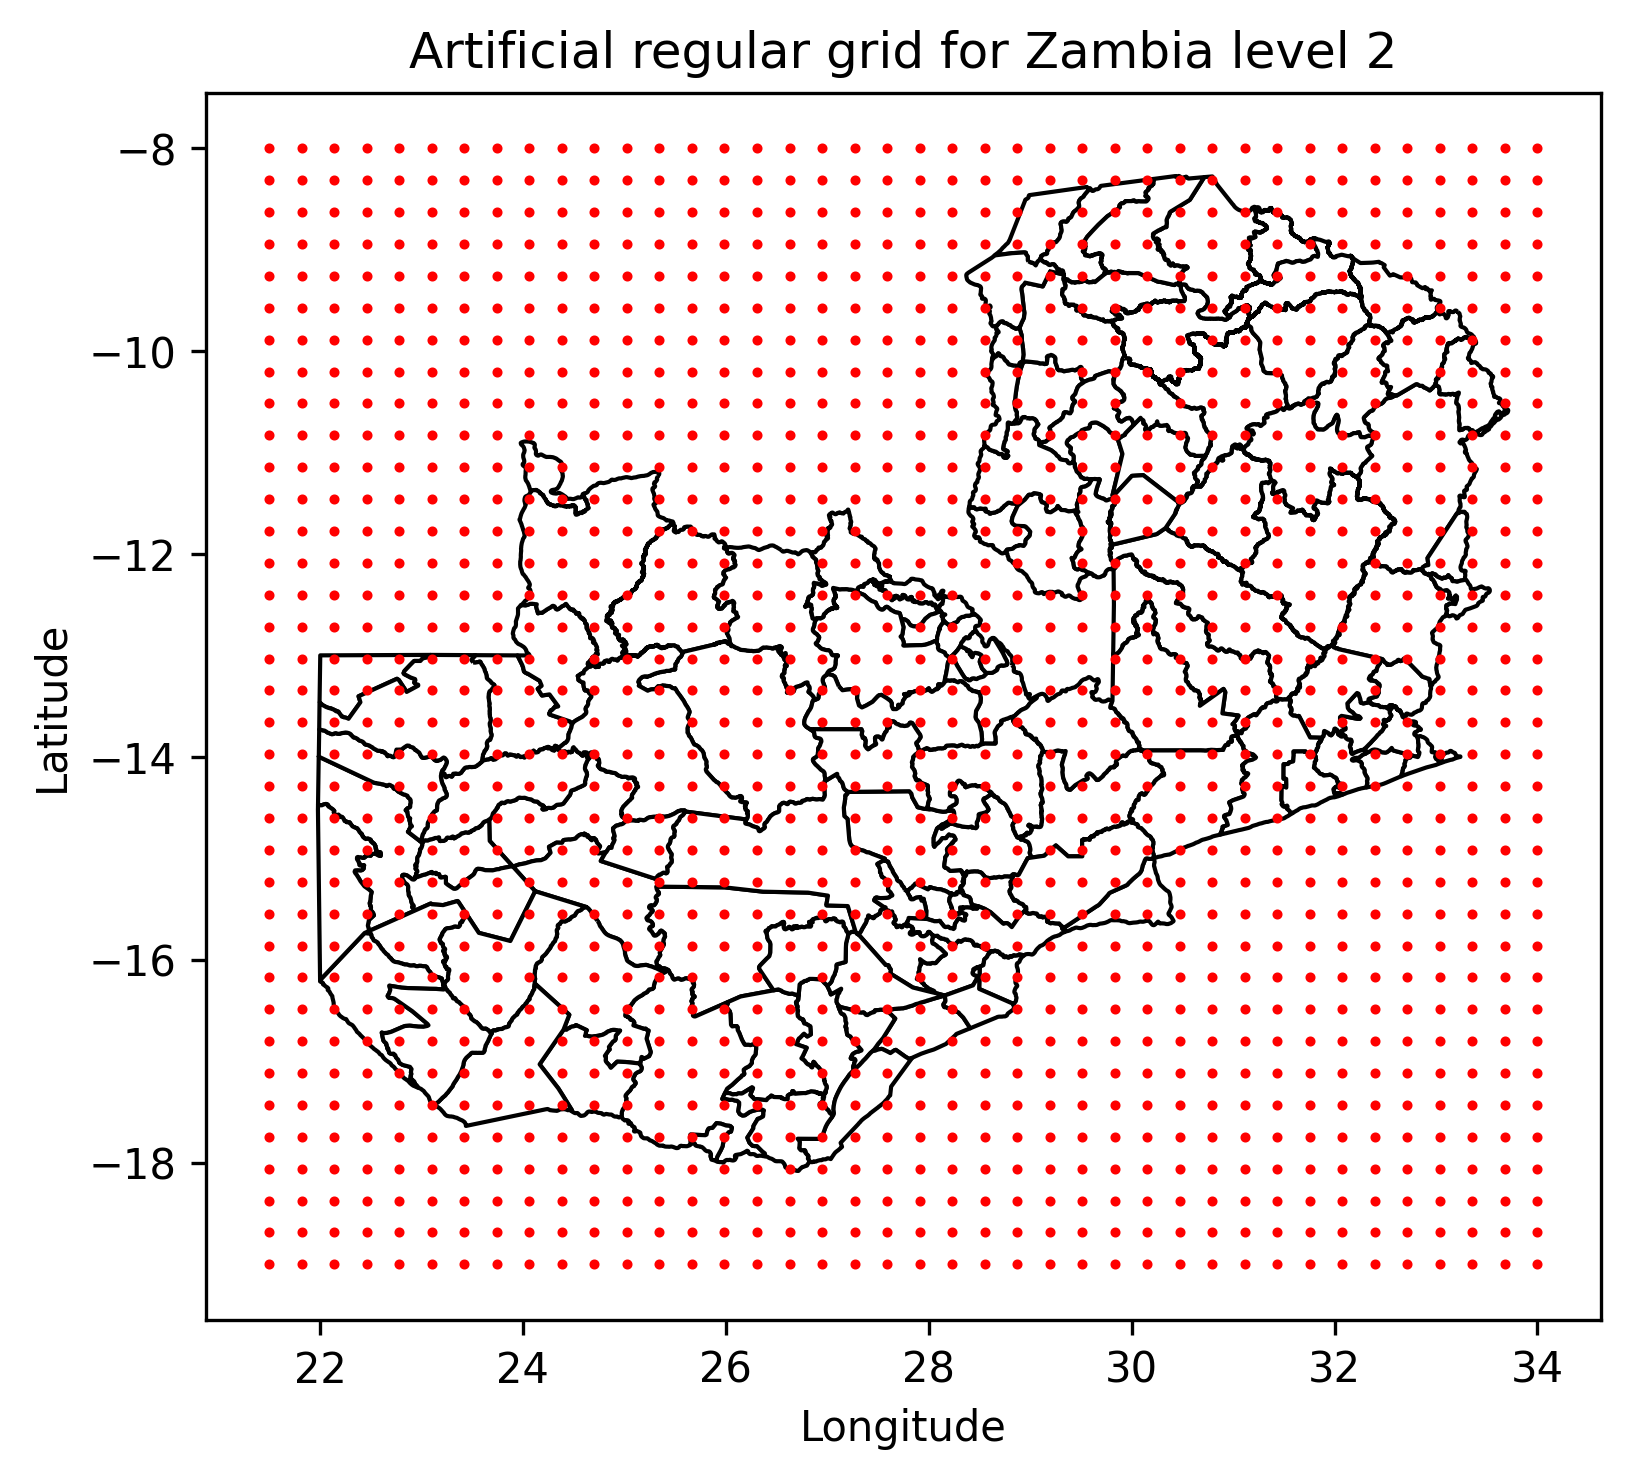

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
divider = make_axes_locatable(ax)
s_new.plot(ax=ax, color='white', edgecolor='black')
grid_pts.plot(ax=ax, marker='o', color='red', markersize=2)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Artificial regular grid for Zambia level {admin_level}')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_regular_grid.pdf')

In [27]:
def pol_pts(shape, grid_pts, min_pts=10):
    grid_pts.set_crs(epsg=4326, inplace=True);
    grid_pts.crs == shape.crs

    n_pol = len(shape.geometry)
    n_pts = len(grid_pts.geometry)

    pl_pt = np.zeros((n_pol, n_pts), dtype=int)

    pt_which_pol = np.zeros(n_pts, dtype=int)

    for i_pol in range(n_pol):
        pol = shape.geometry[i_pol]
        for j_pts in range(n_pts):
            pt = grid_pts.geometry[j_pts]
            if pol.contains(pt):
                pl_pt[i_pol, j_pts] = 1
                pt_which_pol[j_pts] = i_pol + 1 # note the enumeration!


    # ensure a minimum number of points

    pol_sums = np.sum(pl_pt, axis=1)

    fix_pols = np.where(pol_sums<min_pts)[0]

    if fix_pols.size > 0:

      for i_pol in fix_pols:

        # print(f'i_pol:{i_pol}')

        polygon = shape.geometry[i_pol]
        no_points = pol_sums[i_pol]

        extra_len = min_pts - no_points
        minx, miny, maxx, maxy = polygon.bounds
        extra_y_coords = []
        extra_x_coords = []

        main_rng_key = random.PRNGKey(44)

        # print(extra_len)

        while extra_len > 0:
            main_rng_key, rng_key_pts = random.split(main_rng_key)
            random_point_coords = [
                random.uniform(rng_key_pts, (1,), minval=minx, maxval=maxx)[0],
                random.uniform(rng_key_pts, (1,), minval=miny, maxval=maxy)[0]
            ]
            random_point = Point(float(random_point_coords[0]), float(random_point_coords[1]))

            if polygon.contains(random_point):
              # print('Contains random point')
              extra_y_coords.append(random_point.y)
              extra_x_coords.append(random_point.x)
              extra_len -= 1

        # add extra points to grid

        # Create DataFrame for new points
        extra_df = pd.DataFrame({'Latitude': extra_y_coords, 'Longitude': extra_x_coords})
        extra_grid_pts = gpd.GeoDataFrame(extra_df, geometry=gpd.points_from_xy(extra_df.Longitude, extra_df.Latitude))

        # Set CRS for the new GeoDataFrame
        extra_grid_pts.set_crs(epsg=4326, inplace=True)

        # Concatenate the original and new GeoDataFrames
        grid_pts = pd.concat([grid_pts, extra_grid_pts]).reset_index(drop=True)


      # Amend pl_pt and pt_which_pol (outside polygon loop)
      pl_pt, pt_which_pol, _ = pol_pts(shape, grid_pts, min_pts)

    return([pl_pt, pt_which_pol, grid_pts])

In [28]:
pol_pt_new, pt_which_pol_new, grid_pts_new = pol_pts(s_new, grid_pts, min_pts=10)
pol_sums_new = np.sum(pol_pt_new, axis=1) # how many points in each polygon
# print(all(item > 0 for item in pol_sums_new)) # in each polygon there is at least one point
print(all(item >= 10 for item in pol_sums_new)) # in each polygon there is at least 10 points
grid_pts_new['pt_which_pol_new'] = pt_which_pol_new
grid_pts_new

True


Latitude  Longitude                    geometry  pt_which_pol_new
0    -19.000000  21.500000  POINT (21.50000 -19.00000)                 0
1    -19.000000  21.820513  POINT (21.82051 -19.00000)                 0
2    -19.000000  22.141026  POINT (22.14103 -19.00000)                 0
3    -19.000000  22.461538  POINT (22.46154 -19.00000)                 0
4    -19.000000  22.782051  POINT (22.78205 -19.00000)                 0
...         ...        ...                         ...               ...
2013 -17.455769  26.790142  POINT (26.79014 -17.45577)               115
2014 -17.507141  26.722168  POINT (26.72217 -17.50714)               115
2015 -17.777426  26.364519  POINT (26.36452 -17.77743)               115
2016 -17.394756  26.870876  POINT (26.87088 -17.39476)               115
2017 -17.401566  26.861866  POINT (26.86187 -17.40157)               115

[2018 rows x 4 columns]

In [29]:
pol_pt_new.shape

(115, 2018)

In [30]:
pol_sums_new

array([10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 18, 10, 10, 10, 13, 10, 13, 10, 10, 10, 10, 11, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 13, 10, 10, 10, 10, 15, 10, 18, 10, 10, 10, 10, 10,
       17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       11, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 12, 10])

In [31]:
new_y_coords = grid_pts_new['Latitude']
new_x_coords = grid_pts_new['Longitude']
new_x = jnp.array([new_x_coords, new_y_coords]).transpose((1, 0))
print(new_x.shape)

(2018, 2)


In [32]:
grid_pts = grid_pts_new
grid_pts.shape

(2018, 4)

In [33]:
grid_pts['in_out_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 'out' if x==0 else 'in')
grid_pts['marker_size_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 1 if x==0 else 12)
n_pol_new = len(s_new.geometry)

In [34]:
cmap = plt.cm.prism  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

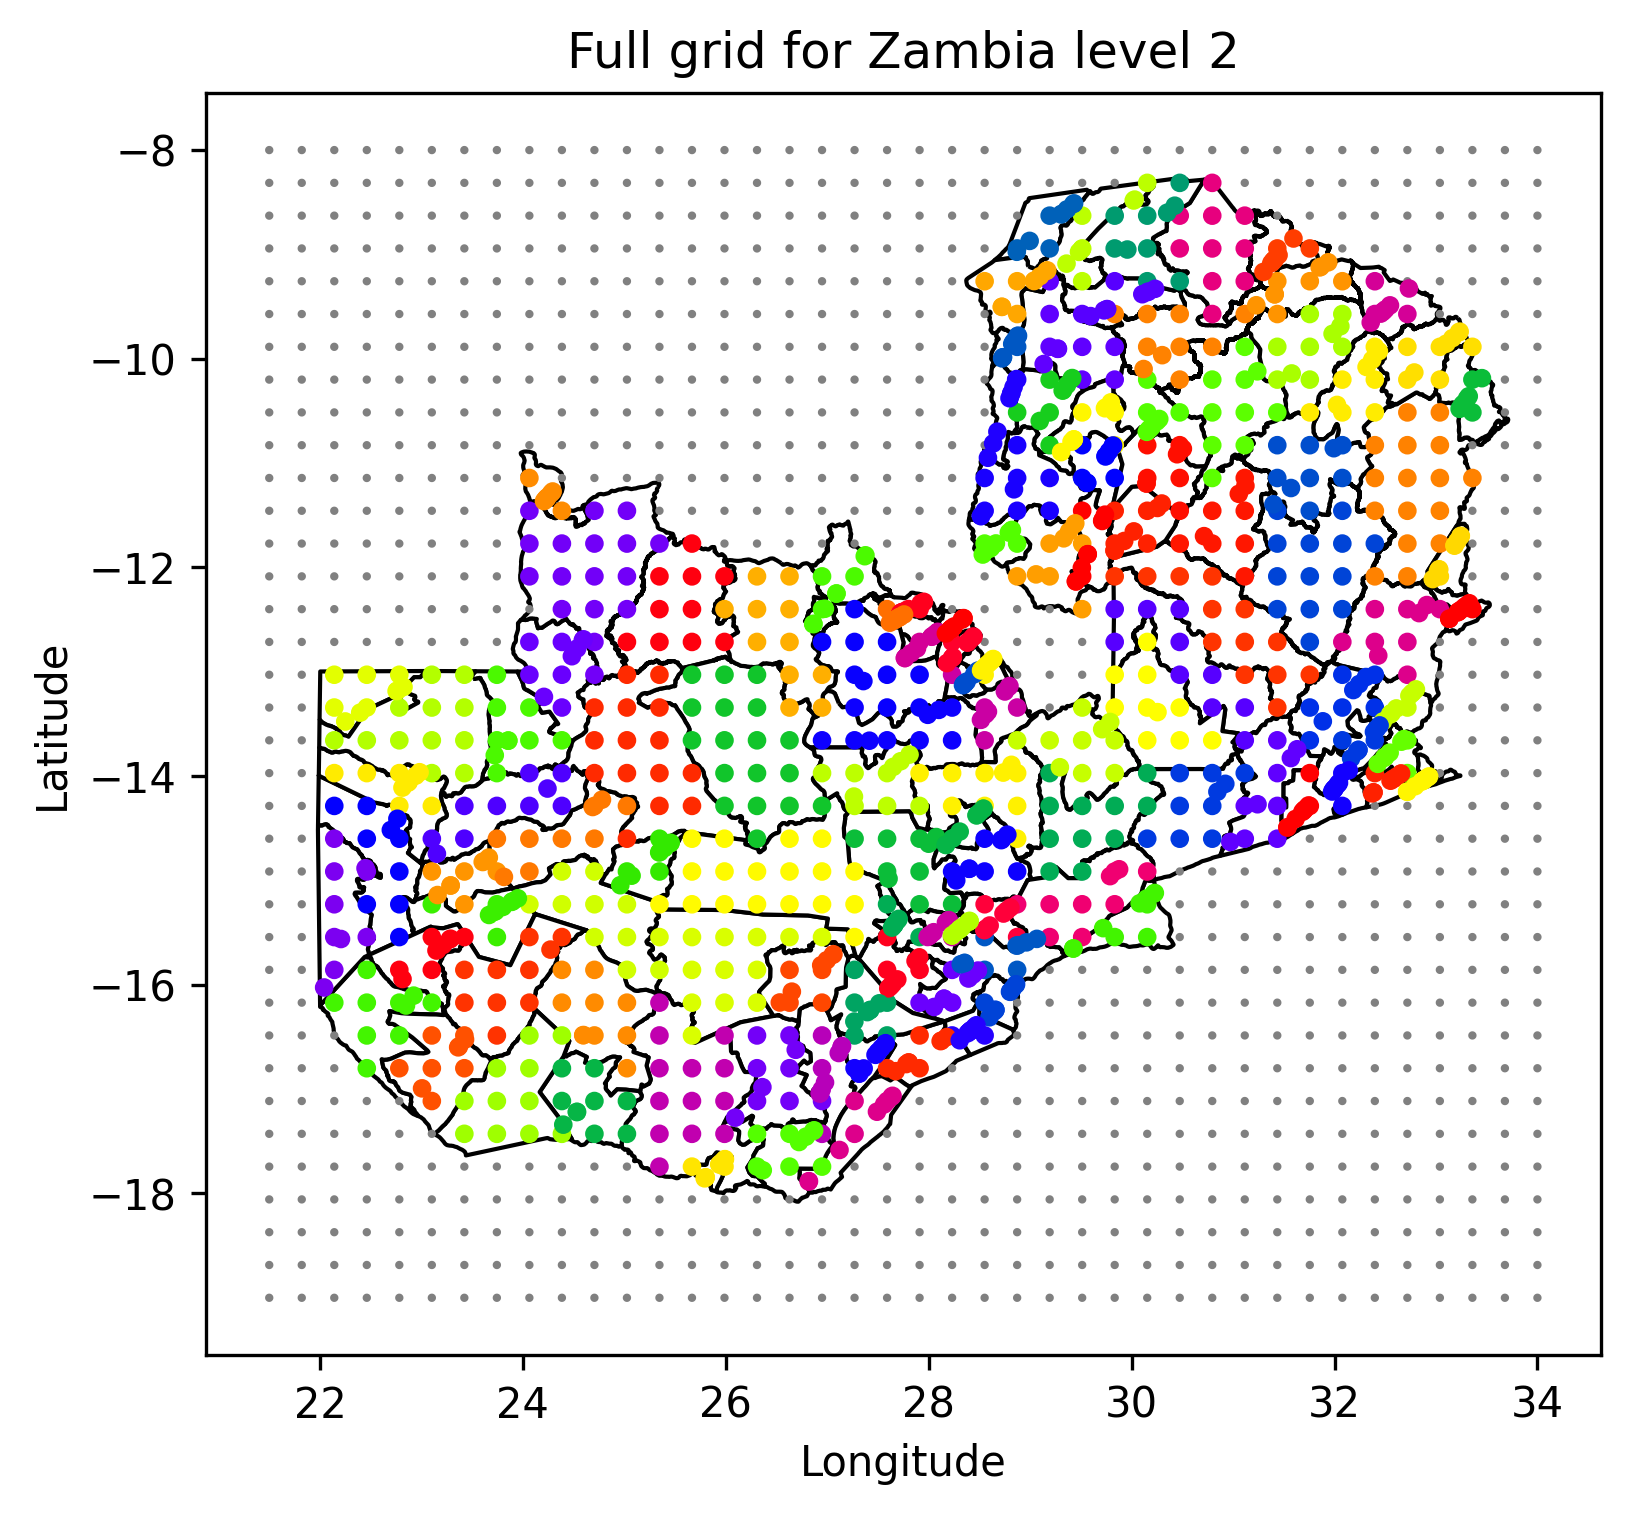

In [35]:
fig, ax2 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
divider = make_axes_locatable(ax)

# define the bins and normalize
bounds_new = np.linspace(min(pt_which_pol_new), max(pt_which_pol_new), n_pol_new)
norm_new = matplotlib.colors.BoundaryNorm(bounds_new, cmap.N)
s_new.plot(ax=ax2, color='white', edgecolor='black')
grid_pts.plot(ax=ax2, marker='o', column='pt_which_pol_new', markersize='marker_size_new', cmap=cmap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Full grid for Zambia level {admin_level}')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_full_segmentation.pdf')

In [36]:
s_new.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292

In [37]:
type(s_new)

geopandas.geodataframe.GeoDataFrame

In [38]:
s = s_new.rename({'Total observations':'n_obs', 'Positive tests count':'y', 'Prevalence estimate':'estimate'}, axis='columns')
# s = pd.concat([s_old, s_new])
s.head()
#print(s.shape)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   
3  CHAVUMA  POLYGON ((21.99573 -13.46393, 21.99610 -13.439...    1  0.438596   
4   CHEMBE  POLYGON ((28.89259 -11.50817, 28.87754 -11.520...    1  0.826087   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292  
3     56   5  0.089286  
4     51   0  0.000000

# Traditional prevalence model

In [39]:
# draw GP samples on the grid

def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

In [40]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

## CVAE architecture

In [41]:
from collections.abc import Callable
from typing import Iterable

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from flax.training.train_state import TrainState
from jax import Array, value_and_grad, jit, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from tqdm.notebook import tqdm

In [42]:
args = {"seed": 0,

        # architecture
        "conditional": True,
        "hidden_dim": 1024,
        "z_dim": 512,

        # data generation
        "new_data": True,  # set to True to generate new data. Otherwise read from file
        "save_data": False, # set to True to save generated training and test datasets
        "batch_size": 100,
        "samples": 5000,

        # VAE setup
        "vae_sd": 1,
        "n_epochs": 100,        # for better results, set to 15000
        "learning_rate": 1e-3,
        "train_vae": True,      # set to True to train VAE
        "save_vae": False,
        "load_vae": False,      # set to True to load trained CVAE
        "decoder_params": None,
        "hyperprior_ls_name": "Gamma(3, 10)",
        "hyperprior_var_name": "Gamma(8, 100)",
        "hyperprior_ls": dist.Gamma(3, 10),
        "hyperprior_var": dist.Gamma(8, 100),

        # MCMC setup
        "num_warmup": 200,
        "num_mcmc_samples": 1000,
        "num_chains": 4,
        "thinning": 1,
        "true_ls": 0.2,

        'n_obs': jnp.array(s.n_obs),
        "x": new_x,
        "gp_kernel": exp_sq_kernel,
        "jitter": 1e-4,
        "M_new": pol_pt_new,
        
        # posterior analysis
        "num_samples_posterior": 1000,

        # VAE training
        "rng_key": random.PRNGKey(5),

       }

In [43]:
model_specs =('_admin' + str(admin_level)+
              '_mcmcsamp' + str(args['num_mcmc_samples'])+
             '_h' + str(args["hidden_dim"])+
             '_z' + str(args["z_dim"])+
             '_epochs' + str(args["n_epochs"])+
             '_ls' + args['hyperprior_ls_name']+
             '_var' + args['hyperprior_var_name'])
print('Model specifications:', model_specs)

Model specifications: _admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)


In [44]:
# Create the new directory
os.makedirs('figures/ZMB2018_aggCVAE'+model_specs, exist_ok=True)

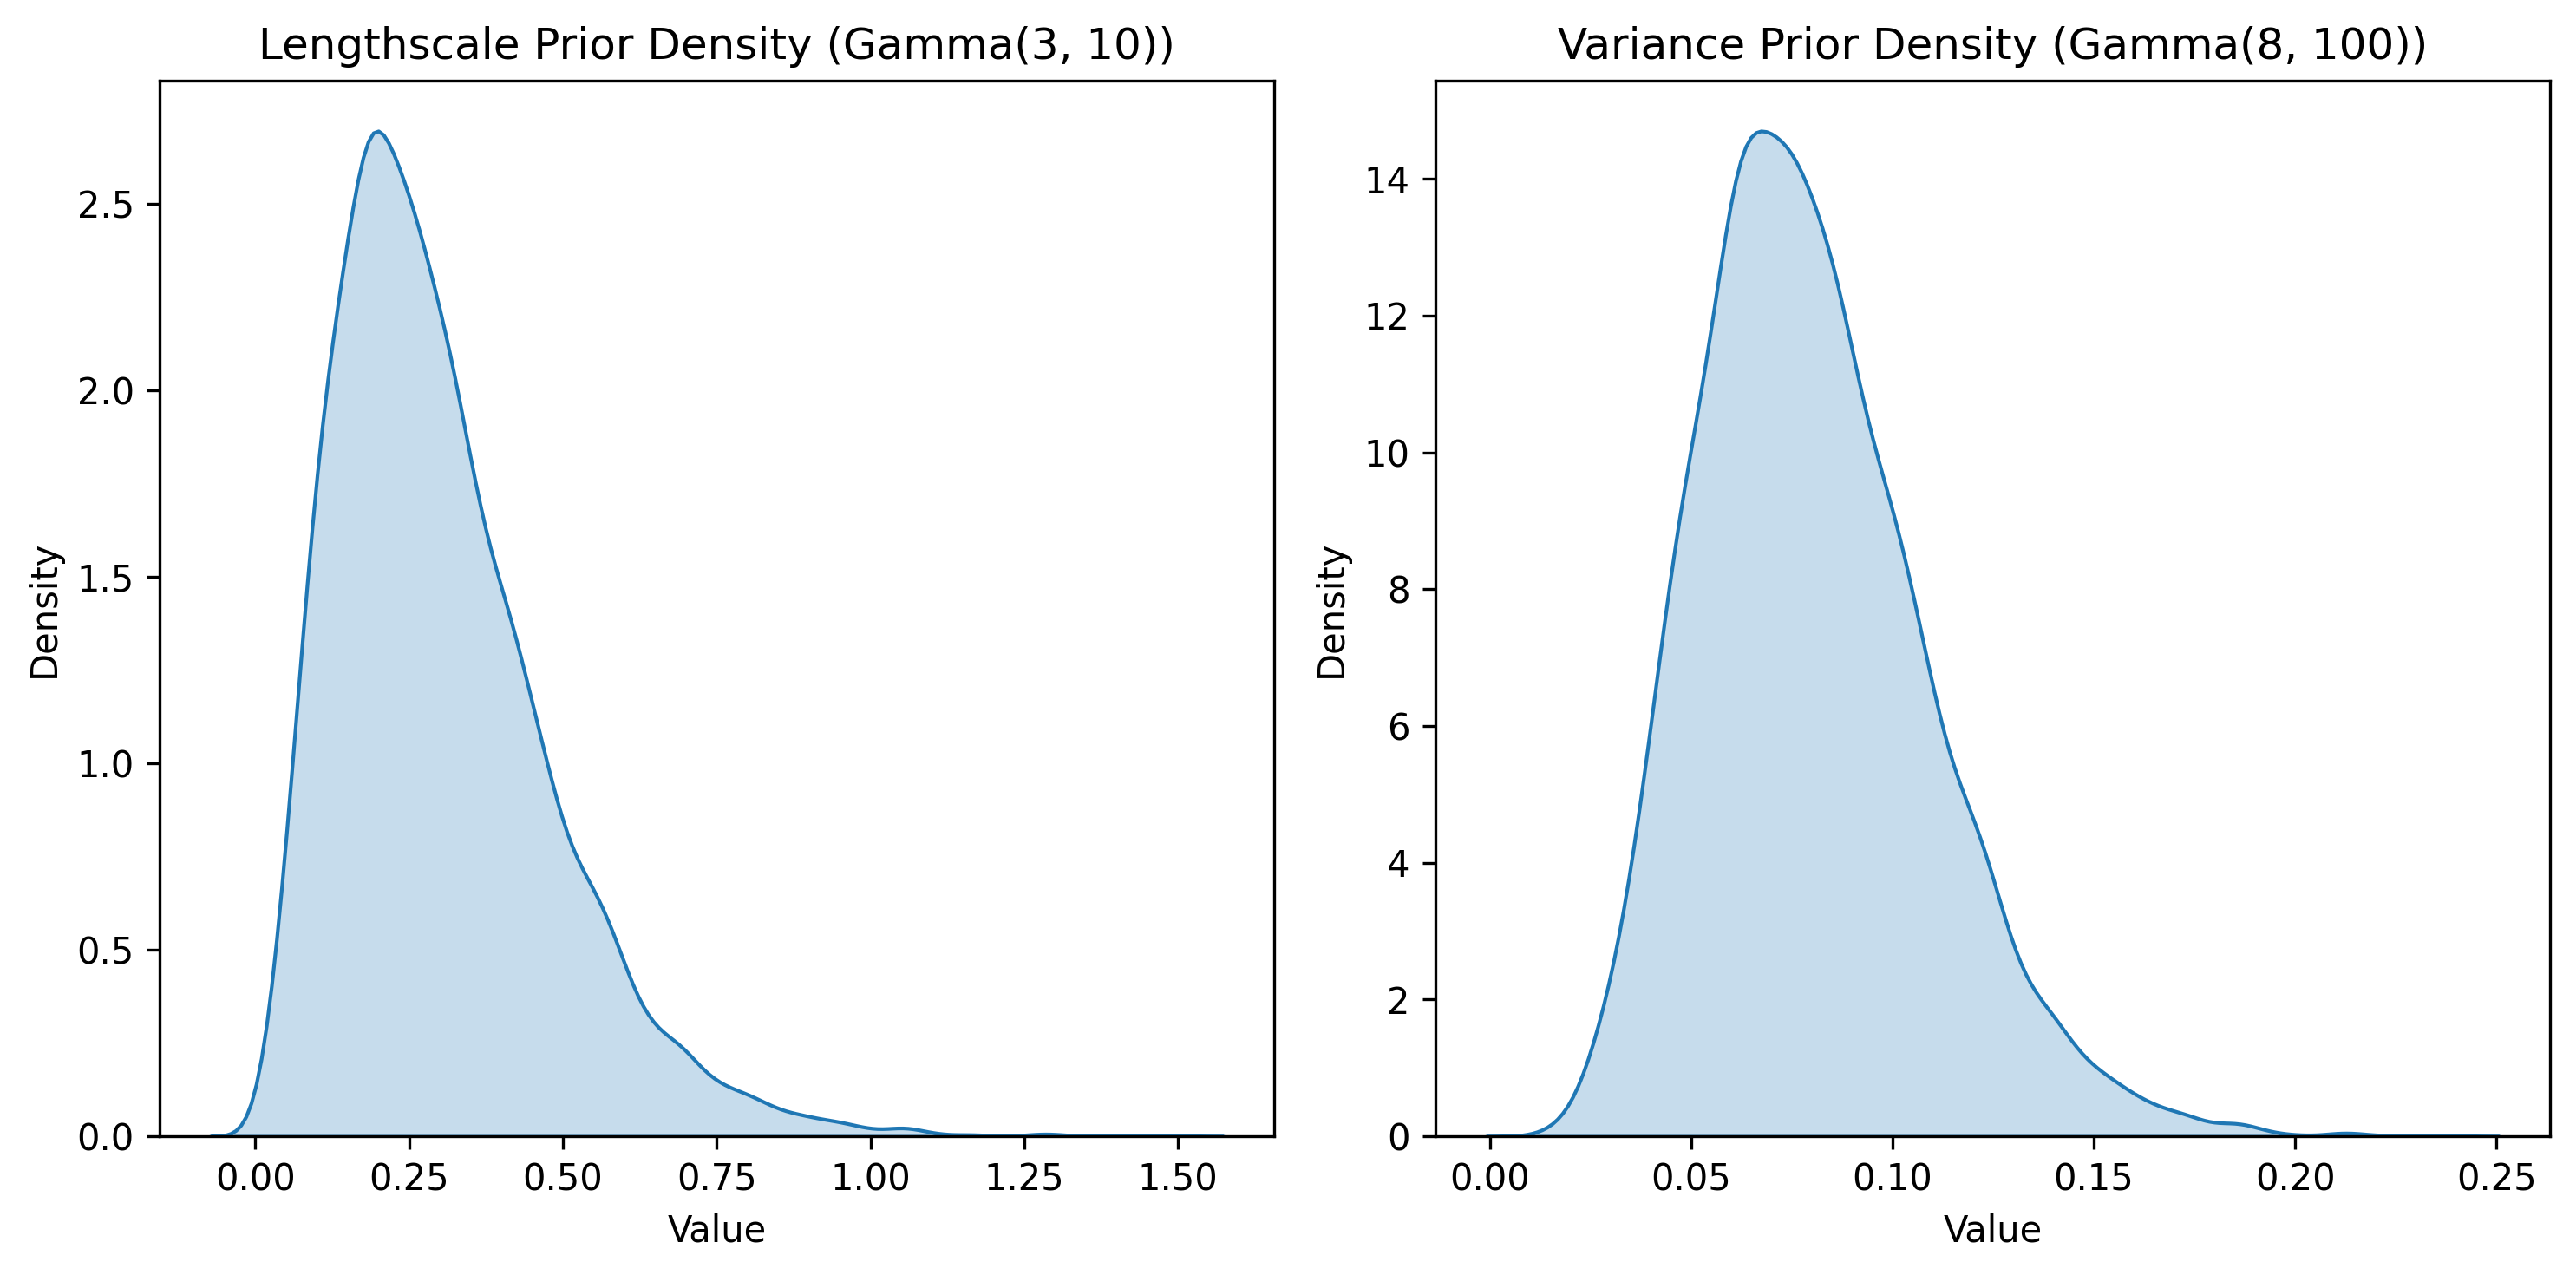

In [45]:
# Plot the hyperpriors
import matplotlib.pyplot as plt
import seaborn as sns
import jax.random as random

# Set random seed for reproducibility
rng_key = random.PRNGKey(0)

# Define the gamma distribution
dist_ls = args['hyperprior_ls']
dist_var = args['hyperprior_var']

# Sample from the gamma distribution
samples_ls = dist_ls.sample(rng_key, (10000,))
samples_var = dist_var.sample(rng_key, (10000,))


# Set plot parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as needed

# Plot the Lengthscale density
sns.kdeplot(samples_ls, ax=axs[0], fill=True)
axs[0].set_title(f'Lengthscale Prior Density ({args["hyperprior_ls_name"]})')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')

# Plot the Variance density
sns.kdeplot(samples_var, ax=axs[1], fill=True)
axs[1].set_title(f'Variance Prior Density ({args["hyperprior_var_name"]})')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+ '_hyperprior_distributions.pdf')
plt.show()

In [46]:
from collections.abc import Callable
from flax import linen as nn


class MLP(nn.Module):
    dims: list[int]
    act_fn: Callable = nn.relu
    p_dropout: float = 0.0

    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.dims[:-1]:
            x = nn.Dense(dim)(x)
            x = self.act_fn(x)
            x = nn.Dropout(self.p_dropout, deterministic=not training)(x)
        return nn.Dense(self.dims[-1])(x)

In [47]:
#!/usr/bin/env python3
import jax.numpy as jnp
from flax import linen as nn
from jax import Array, random


class PriorCVAE(nn.Module):
    r"""[PriorCVAE](https://arxiv.org/pdf/2304.04307) approximates a Gaussian Process.

    Once trained, the module's `decoder` can be used as a generative
    model to simulate a GP from the samples it was trained on.

    Args:
        encoder: A module used to encode GP realizations and
            their hyperparamters.
        decoder: A module used to decode random vectors and
            GP hyperparameters into GP samples.
        z_dim: The size of the hidden dimension.

    Returns:
        An instance of the PriorCVAE network.
        $\hat{\mathbf{f}}$, a recreation of the original $\mathbf{f}$,
        along with $\mu$ and $\log(\sigma^2)$, which are often used
        to calculate losses involving KL divergence.
    """

    encoder: nn.Module
    decoder: nn.Module
    z_dim: int

    @nn.compact
    def __call__(self, rng: Array, var: float, ls: float, f: Array):
        r"""Run module forward.

        Args:
            rng: A pseudo-random number generator.
            var: The variance for the GP.
            ls: The lengthscale for the GP.
            f: The function values, an array of shape `(B, K, 1)`.

        Returns:
            $\hat{\mathbf{f}}$, a recreation of the original$\mathbf{f}$,
            along with $\mu$ and $\log(\sigma^2)$, which are often used
            to calculate losses involving KL divergence.
        """
        batch_size = f.shape[0]
        var = jnp.full((batch_size, 1), var)
        ls = jnp.full((batch_size, 1), ls)
        f_flat = f.reshape(batch_size, -1)
        latents = self.encoder(jnp.hstack([f_flat, var, ls]))
        mu = nn.Dense(self.z_dim)(latents)
        log_var = nn.Dense(self.z_dim)(latents)
        std = jnp.exp(log_var / 2)
        eps = random.normal(rng, log_var.shape)
        z = mu + std * eps
        f_hat = self.decoder(jnp.hstack([z, var, ls]))
        return f_hat.reshape(f.shape), mu, log_var
    
    def decode(self, z: Array, var: float, ls: float):
        B = z.shape[0]
        var = jnp.full((B, 1), var)
        ls = jnp.full((B, 1), ls)
        return self.decoder(jnp.hstack([z, var, ls]))

In [48]:
def build_prior_cvae(num_s: int = 64, z_dim: int = 64, hidden_dim: int = 256):
    encoder = MLP([hidden_dim, z_dim])
    decoder = MLP([hidden_dim, num_s])
    return PriorCVAE(encoder, decoder, z_dim)

@jit
def prior_cvae_train_step(rng, state, batch):
    def elbo_loss(params):
        _s, f, ls, var  = batch
        f_hat, z_mu, z_log_var = state.apply_fn({"params": params}, rng, var, ls, f)
        kl_div = (0.5 * (jnp.exp(z_log_var) + jnp.square(z_mu) - 1 - z_log_var)).mean()
        logp = norm.logpdf(f, f_hat, 1.0).mean()
        return -logp + kl_div

    loss, grads = value_and_grad(elbo_loss)(state.params)
    return state.apply_gradients(grads=grads), loss

In [49]:
model_args = args
n_samples = args['samples']
num_epochs = args['n_epochs']
x = args['x']

# num_s is 10 for admin 1 because there are 10 polygons, i.e. the K in (B, K, 1)
if admin_level == 1:
    num_s = 10
if admin_level == 2:
    num_s  = 115

batch_size = args['batch_size']

# Train VAE

In [50]:
def gp_aggr(args):

    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", args['hyperprior_ls'])
    variance = numpyro.sample("kernel_var", args['hyperprior_var'])
    k = gp_kernel(x, x, variance, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    gp_aggr = numpyro.deterministic('gp_aggr', gp_aggr_new)
    ls = numpyro.deterministic('ls', length)
    var = numpyro.deterministic('var', variance)

In [51]:
pol_pt_new.shape

(115, 2018)

In [52]:
# aggGP: prior predictive
rng_key, rng_key_ = random.split(random.PRNGKey(4))
agg_gp_predictive = Predictive(gp_aggr, num_samples=args['num_samples_posterior'])
agg_gp_preds = agg_gp_predictive(rng_key_, args)
agg_gp_draws = agg_gp_preds['gp_aggr_new']
ls_draws = agg_gp_preds['ls']
var_draws = jnp.array(agg_gp_preds['var'])

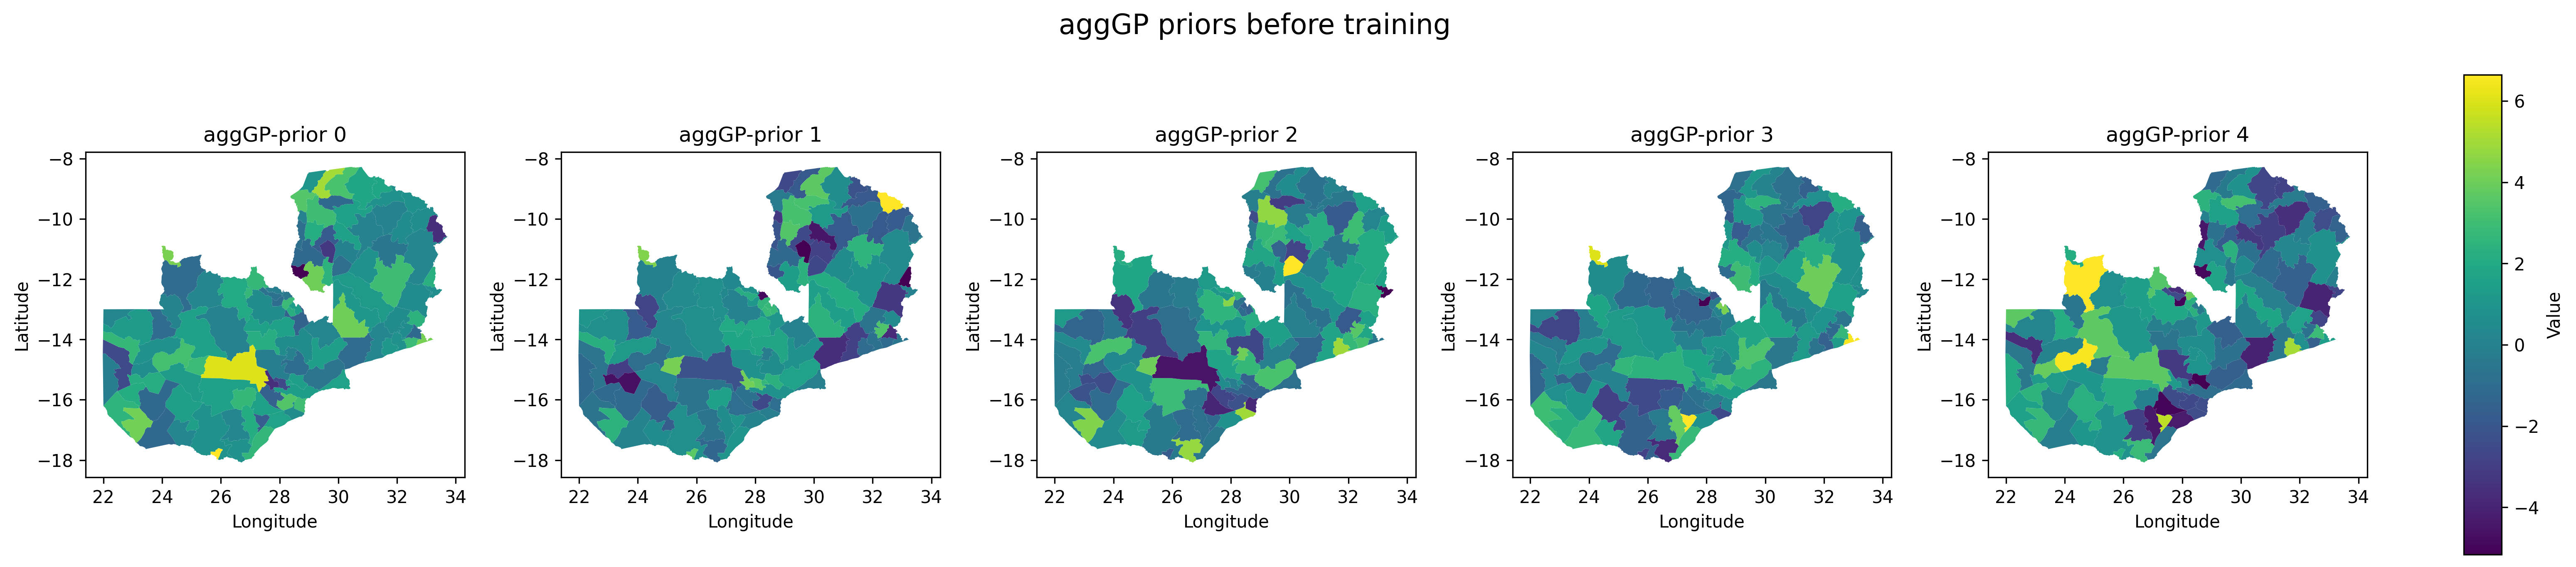

In [53]:
import matplotlib.gridspec as gridspec

s_new_plot = s.copy()

# Create a figure with a gridspec
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], wspace=0.3)  # Adjust wspace for more horizontal space

axs = [fig.add_subplot(gs[i]) for i in range(5)]

# Plot each column in a separate subplot
for i in range(5):
    nm = 'gp_aggr_' + str(i)
    s_new_plot[nm] = agg_gp_draws[i, :]
    s_new_plot.plot(column=nm, ax=axs[i], legend=False)
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_title(f'aggGP-prior {i}')

# Add an overall title
fig.suptitle('aggGP priors before training', fontsize=16)

# Create a colorbar
cbar_ax = fig.add_subplot(gs[5])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_new_plot[nm].min(), vmax=s_new_plot[nm].max()))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel('Value')

# Save the figure
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_priors_before_training.pdf')
plt.show()

In [54]:
# have to add number of epochs in training so that the name is relevant
model_save_name = f'aggCVAE_decoder' + model_specs
PATH = F"decoders/{model_save_name}"
PATH_loss = F"losses/{model_save_name}"

In [55]:
# Load
# PATH = "decoders/AggCVAE_admin2_decoder_n80_h60_z40_epochs100_lsGamma(3, 10)_varGamma(9, 100)"
with open(PATH, 'rb') as file:
   decoder_params = pickle.load(file)
   print(len(decoder_params))

args["decoder_params"] = decoder_params

2


In [56]:
with open(PATH_loss, 'rb') as file:
   losses_save = pickle.load(file)

train_losses_save = losses_save['train_losses']
val_losses_save = losses_save['val_losses']

print(losses_save)

{'train_losses': array([3.15450788, 2.2016089 , 2.02808046, 1.94476938, 1.89596772,
       1.86218047, 1.83598173, 1.81541622, 1.79894638, 1.78514123,
       1.77251565, 1.76137006, 1.74640763, 1.73555279, 1.72773921,
       1.71513307, 1.70064819, 1.68675625, 1.67369163, 1.65902853,
       1.64441442, 1.63017607, 1.61449349, 1.60058224, 1.58768868,
       1.57406974, 1.56112564, 1.54951644, 1.53643429, 1.5273602 ,
       1.51694357, 1.5083313 , 1.50141847, 1.49368191, 1.48750794,
       1.48001504, 1.47371745, 1.46746016, 1.46357322, 1.46011591,
       1.45669222, 1.45199525, 1.4485321 , 1.44601107, 1.44416153,
       1.44080579, 1.43919623, 1.43632352, 1.43294525, 1.43226576,
       1.43168366, 1.42590141, 1.4279896 , 1.42430937, 1.42356837,
       1.42188919, 1.42098188, 1.42056823, 1.41851008, 1.41835415,
       1.41449583, 1.41562009, 1.41346431, 1.41270876, 1.41217446,
       1.41058373, 1.4105978 , 1.41120493, 1.40886772, 1.40843987,
       1.40971398, 1.40743315, 1.40723145, 1.

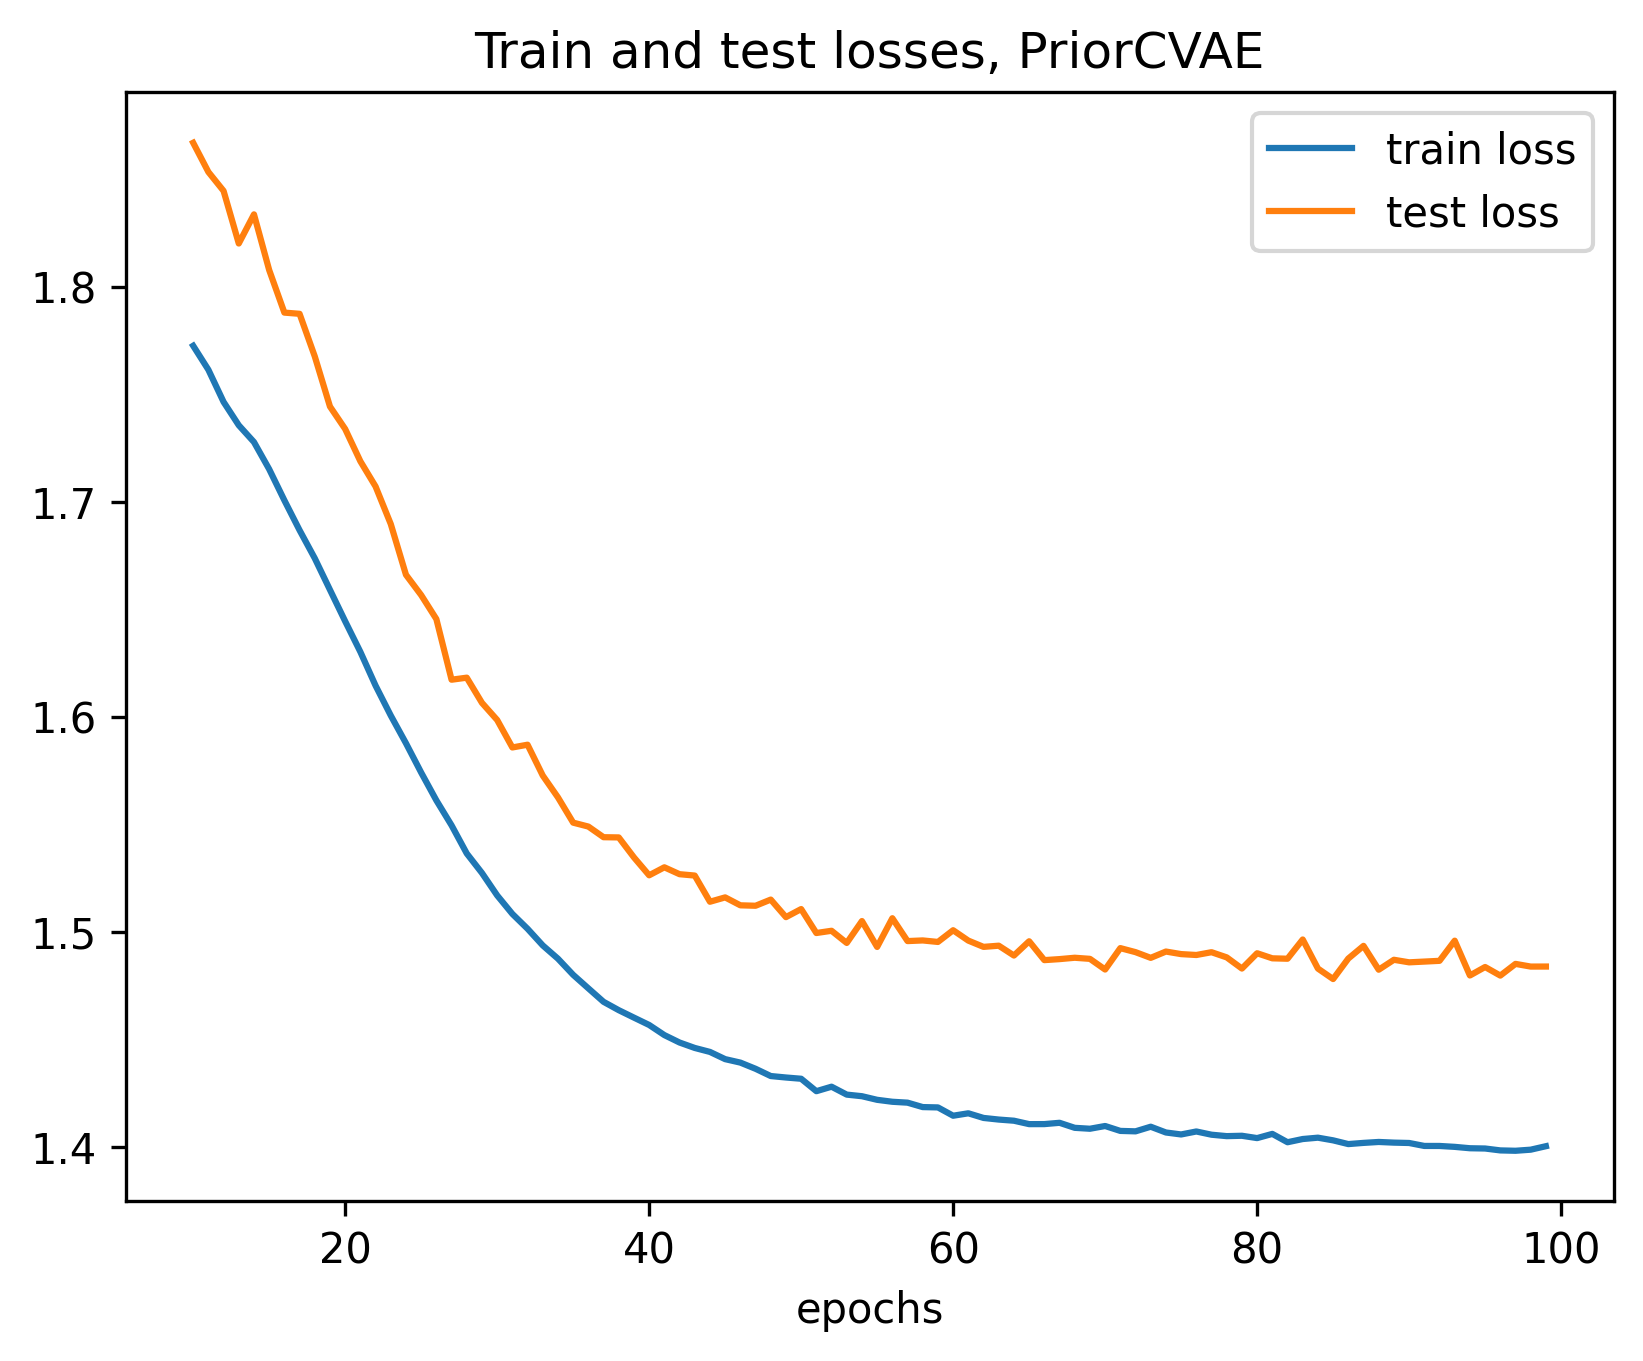

In [57]:
plt.plot(np.arange(10, len(train_losses_save), 1), train_losses_save[10:], label="train loss")
plt.plot(np.arange(10, len(val_losses_save), 1), val_losses_save[10:], label="test loss")
plt.xlabel("epochs")
plt.legend()
plt.title("Train and test losses, PriorCVAE")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_loss_short.pdf')

In [58]:
def vae_sample(args):

    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance

    # will have to change to match closer to reality
    var = numpyro.sample("var", args['hyperprior_var'])
    ls = numpyro.sample("ls", args['hyperprior_ls'])
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    
    prior_cvae_sample = build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim = args['hidden_dim'])
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)

In [59]:
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
vae_predictive = Predictive(vae_sample, num_samples=args['num_samples_posterior'])
vae_draws = vae_predictive(rng_key_predict, args)['vae_aggr']

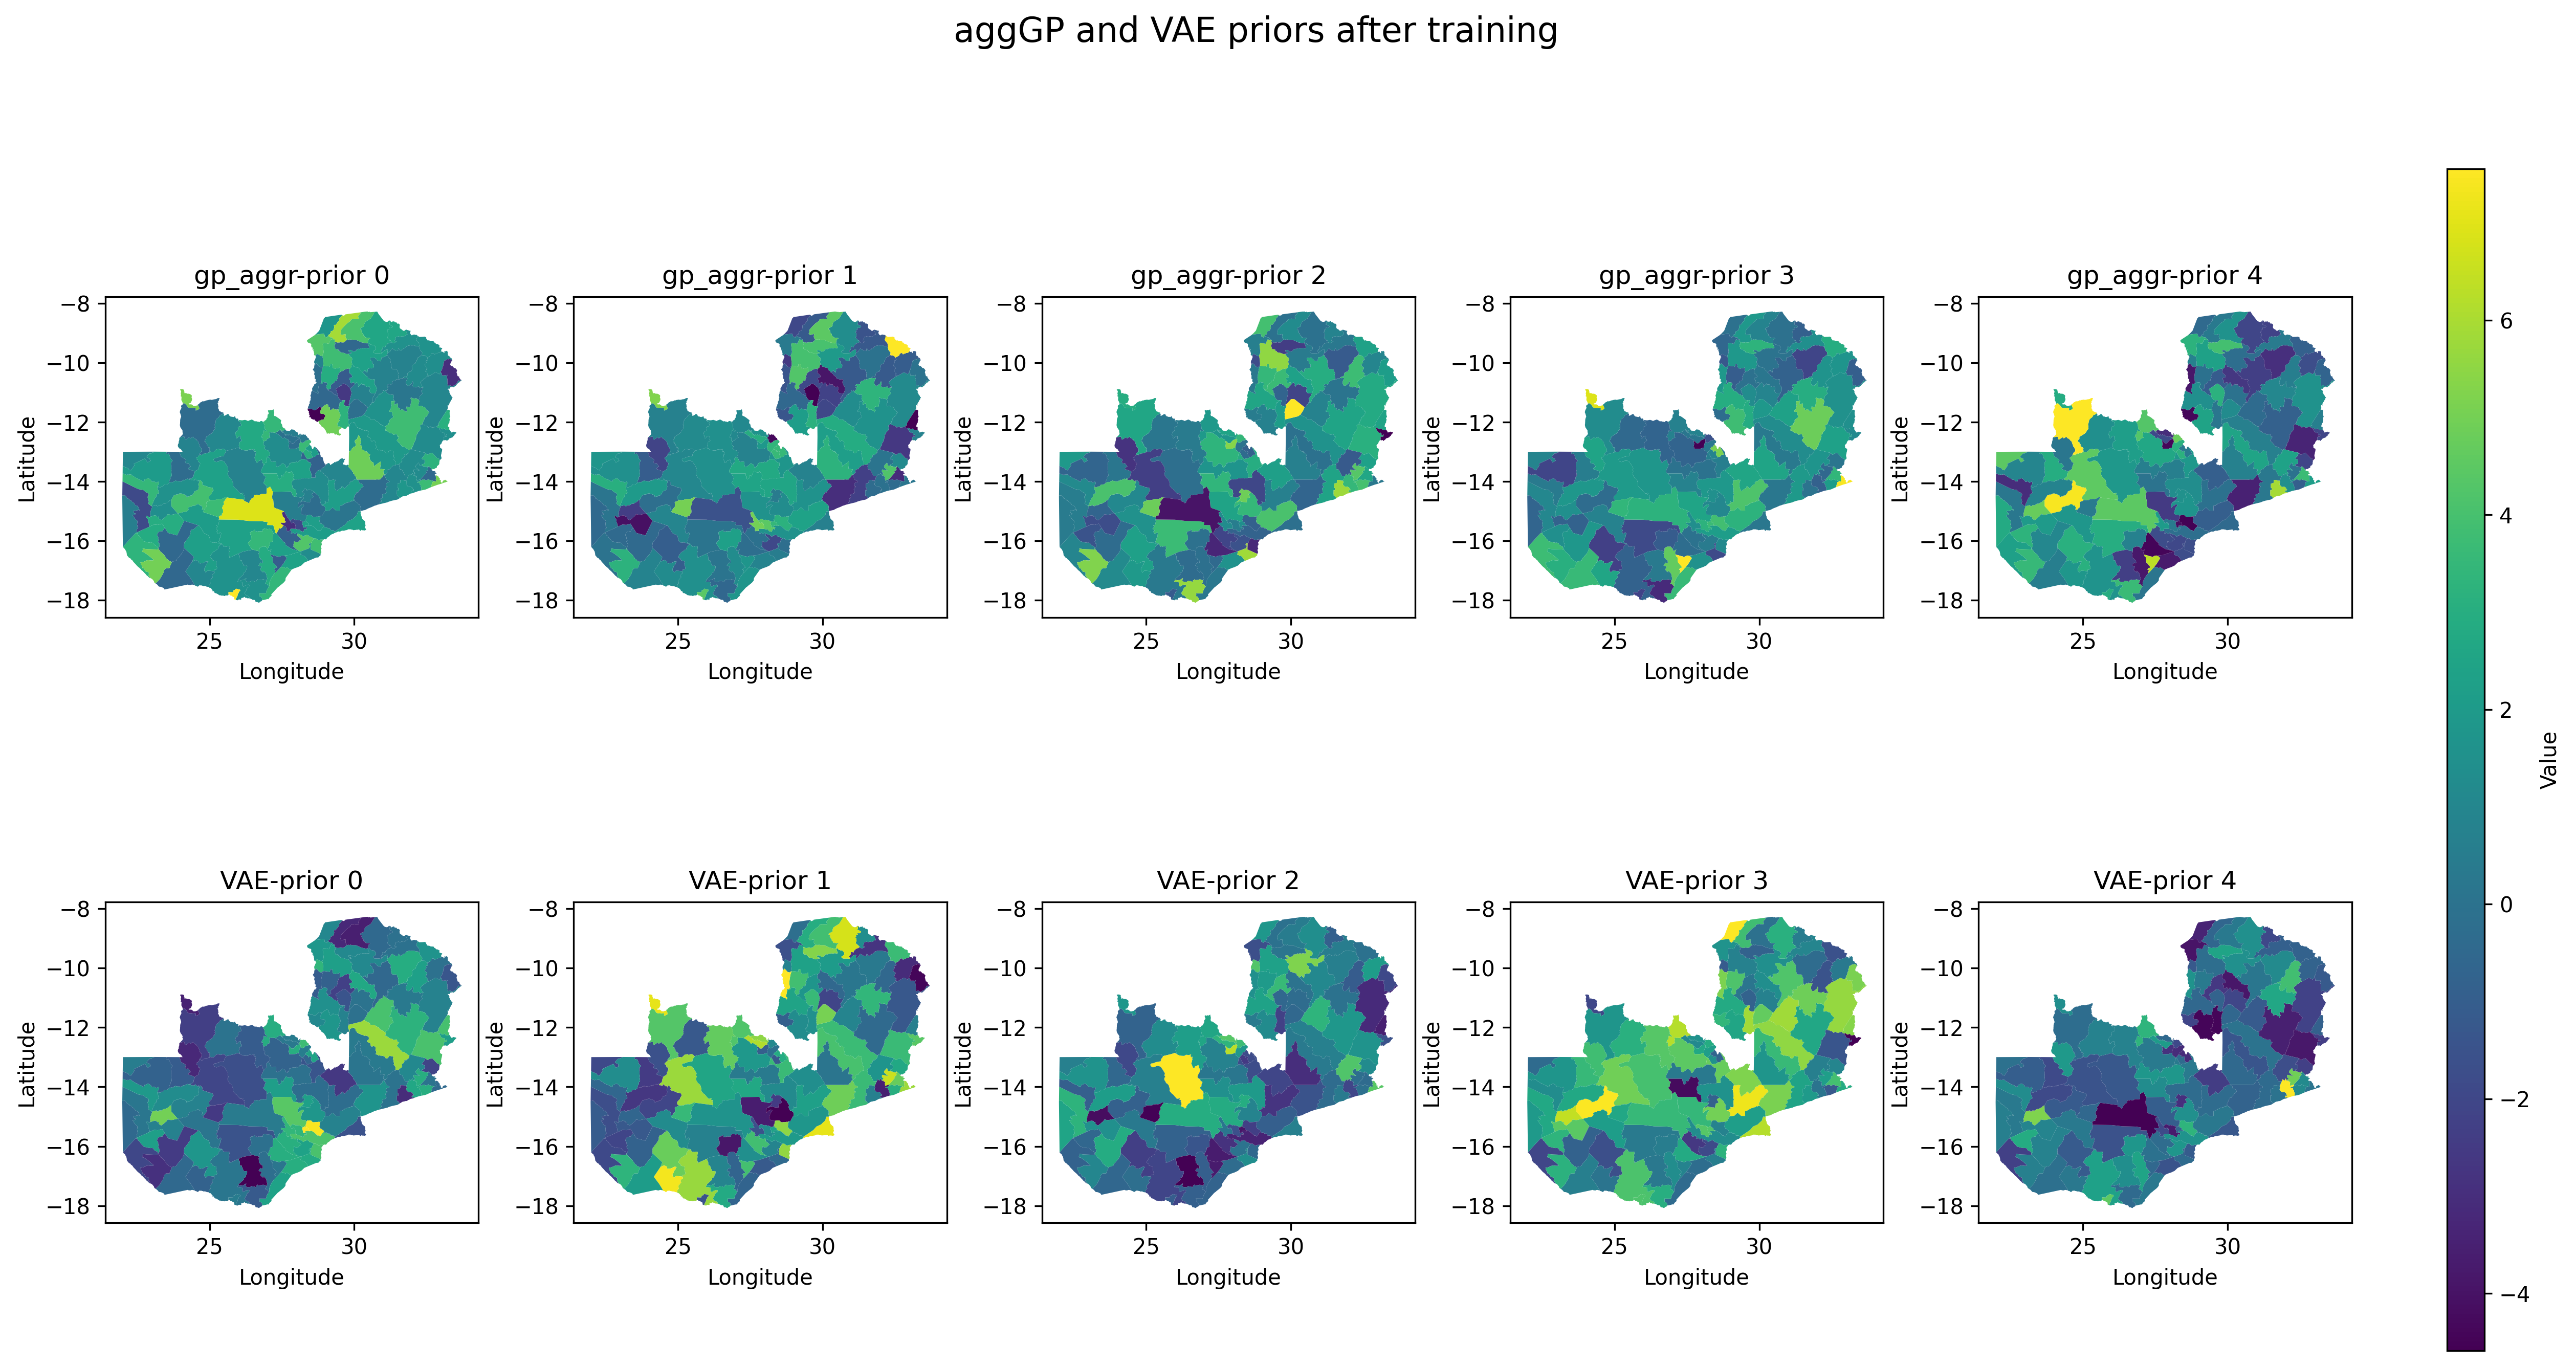

In [60]:
# Create a figure with a gridspec
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], height_ratios=[1, 1], wspace=0.3, hspace=0.05)  # Adjust wspace and hspace for more space between plots

axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]

# Plot aggGP priors
for i in range(5):
    nm = 'gp_aggr_' + str(i)
    s_new_plot[nm] = agg_gp_draws[i, :]
    s_new_plot.plot(column=nm, ax=axs[i], legend=False)
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_title(f'gp_aggr-prior {i}')

# Plot VAE priors
for i in range(5):
    nm = 'vae_draw_' + str(i)
    s_new_plot[nm] = vae_draws[i][0]
    s_new_plot.plot(column=nm, ax=axs[5 + i], legend=False)
    axs[5 + i].set_xlabel('Longitude')
    axs[5 + i].set_ylabel('Latitude')
    axs[5 + i].set_title(f'VAE-prior {i}')

# Add an overall title
fig.suptitle('aggGP and VAE priors after training', fontsize=16)

# Create a shared colorbar
cbar_ax = fig.add_subplot(gs[:, 5])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_new_plot[nm].min(), vmax=s_new_plot[nm].max()))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel('Value')


# Save the figure
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_VAE_priors_after_training.pdf')
plt.show()

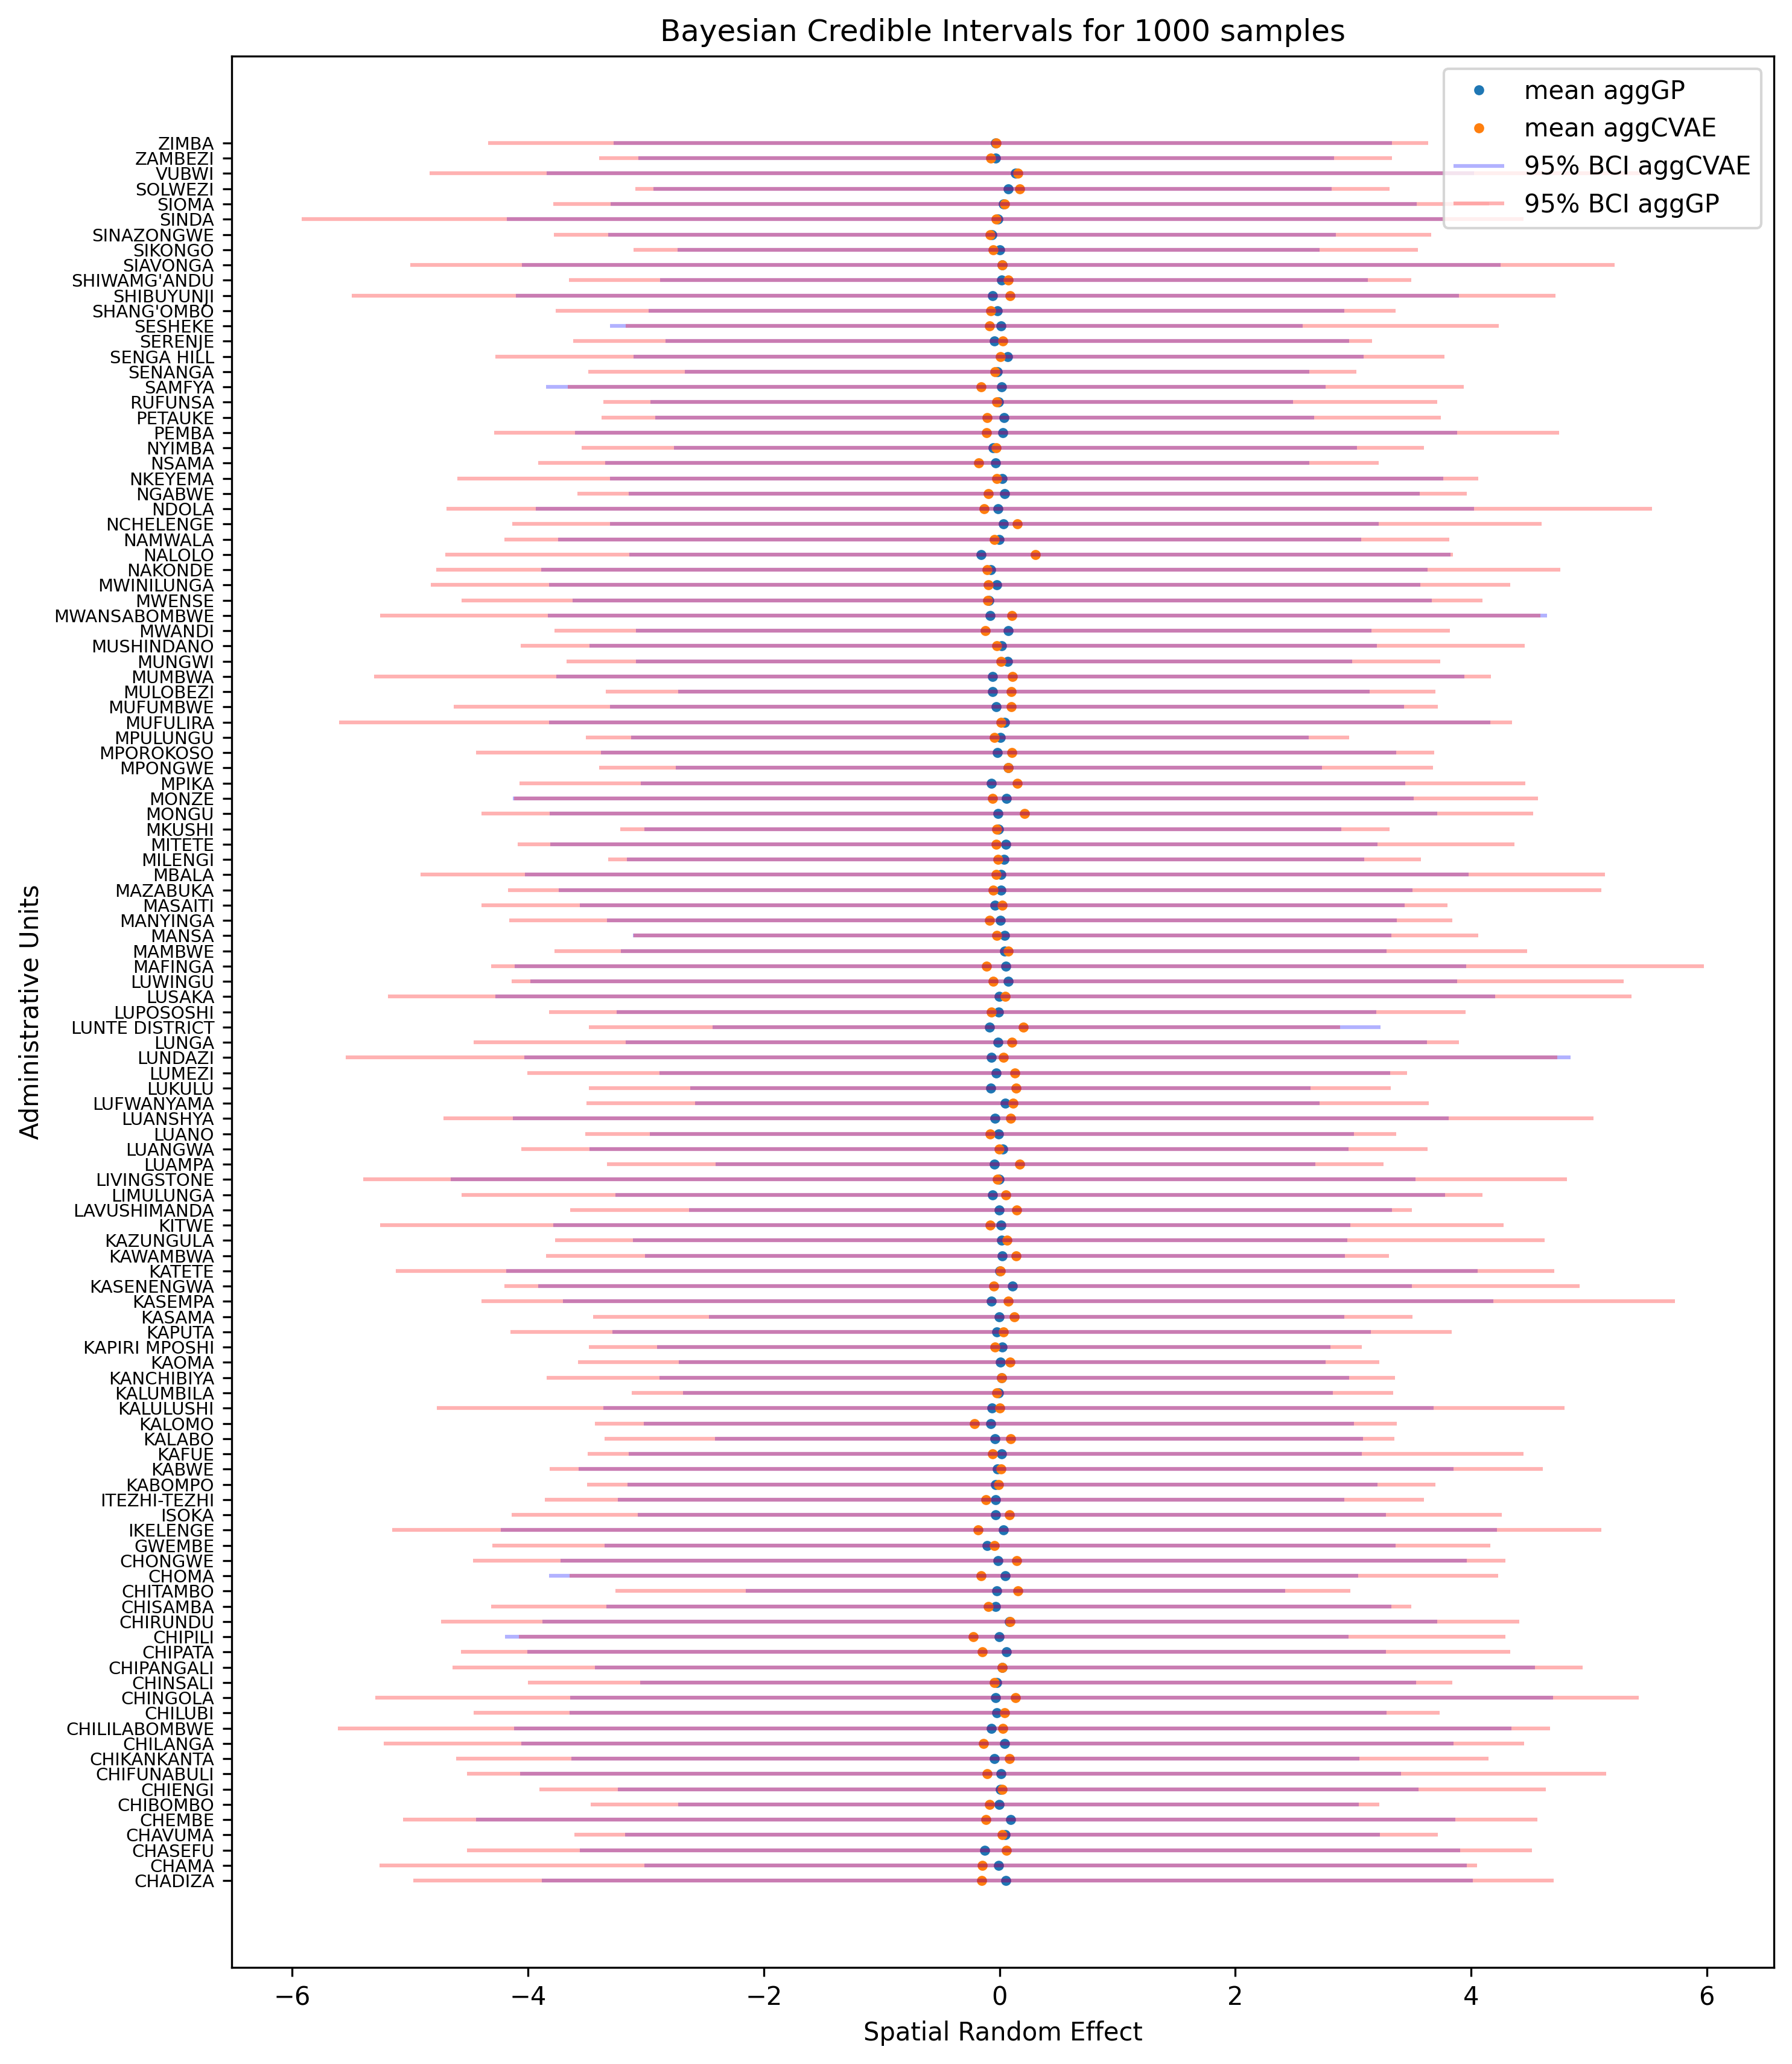

In [61]:
mean_vae_draws = jnp.mean(vae_draws, axis=0)
hpdi_vae_draws = hpdi(vae_draws, 0.95)
mean_gp_aggr = jnp.mean(agg_gp_draws, axis=0)
hpdi_gp_aggr = hpdi(agg_gp_draws,  0.95)

x = np.arange(0, s.shape[0], 1)

# Sort values for plotting by x axis
idx = jnp.argsort(x)
x_axis = s['area']

mean_cvae = mean_vae_draws[1][idx]
mean_gp = mean_gp_aggr[idx]

hpdi_cvae = hpdi_vae_draws[:, :, idx]
hpdi_gp = hpdi_gp_aggr[:, idx]

# Calculate reasonable figure height based on the number of administrative units
fig_height = max(len(x_axis) * 0.1, 8)  # Adjust 0.4 as needed to fit the labels comfortably


# Plot with flipped axes
plt.figure(figsize=(10, fig_height))  # Increase the height of the figure
plt.plot(mean_gp, x_axis, ".", label="mean aggGP")
plt.plot(mean_cvae, x_axis, ".", label="mean aggCVAE") 
plt.hlines(x_axis, xmin=hpdi_cvae[0][0], xmax=hpdi_cvae[1][0], colors="blue", alpha=0.3, label="95% BCI aggCVAE")  # Flipped axes
plt.hlines(x_axis, xmin=hpdi_gp[0], xmax=hpdi_gp[1], colors="red", alpha=0.3, label="95% BCI aggGP")              # Flipped axes
plt.legend()
plt.xlabel('Spatial Random Effect')
plt.ylabel('Administrative Units')
plt.title(f'Bayesian Credible Intervals for {args["num_samples_posterior"]} samples')

# Adjust y-axis ticks and label spacing
plt.yticks(np.arange(len(x_axis)), x_axis, fontsize=7)  # Customize fontsize and spacing

# Save plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_BCI_intervals_priors_after_training.pdf')
plt.show()

## Prevalence model - VAE

In [62]:
def prev_model_vae_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    
    # hyperparameters
    ls = numpyro.sample("kernel_length", args['hyperprior_ls'])
    var = numpyro.sample("kernel_var", args['hyperprior_var'])

#     ls = 0.35
#     var = 0.008
    
    # random effect
    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    prior_cvae_sample =  build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim=args['hidden_dim'])
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)
    
    s = numpyro.sample("sigma", dist.HalfNormal(50))
    vae = numpyro.deterministic('vae', s * vae_aggr)

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    lp = b0 + vae
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [63]:
# load MCMC
# with open(f"MCMCs/ZMB2018_aggCVAE_admin2_mcmc_n80_h60_z40_epochs100_lsGamma(3, 10)_varGamma(9, 100)", 'rb') as file:
#    mcmc_vae = dill.load(file)

with open(f"MCMCs/ZMB2018_aggCVAE"+ model_specs + "mcmc", 'rb') as file:
   mcmc_vae = dill.load(file)

In [64]:
# Save the text content to a pickle file
text_file_name = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_mcmc_summary_text.pkl'


# Save the LaTeX content to a separate pickle file
latex_file_name = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_mcmc_summary_ltex.pkl'


print(f"Text content has been saved to {text_file_name}")
print(f"LaTeX content has been saved to {latex_file_name}")

# To load the text content back from the pickle file (for verification)
with open(text_file_name, 'rb') as text_file:
    loaded_text_content = pickle.load(text_file)
    print("Loaded text content:")
    print(loaded_text_content)
    
# Load and verify the LaTeX table
with open(latex_file_name, 'rb') as file:
    latex_data = pickle.load(file)
    print("\nLoaded from LaTeX file:")
    print(latex_data)
    

# Save the LaTeX content to a .tex file
tex_file_name = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_mcmc_summary_latex.tex'
with open(tex_file_name, 'w') as tex_file:
    tex_file.write(latex_data)
print(f"LaTeX table has been saved to {tex_file_name}")

# Load and verify the LaTeX table from the .tex file
with open(tex_file_name, 'r') as tex_file:
    latex_from_tex_file = tex_file.read()
    print("\nLoaded from .tex file:")
    print(latex_from_tex_file)

Text content has been saved to figures/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)_mcmc_summary_text.pkl
LaTeX content has been saved to figures/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)_mcmc_summary_latex.pkl
Loaded text content:
MCMC elapsed time: 108 s
Average ESS for all aggVAE effects: 4442
Average ESS for all aggVAE-new effects: 4442
Max r_hat for all aggVAE-new effects: 1.0
MCMC elapsed time: 108 s
Average ESS for all VAE-CAR effects: 4442



FileNotFoundError: [Errno 2] No such file or directory: 'figures/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)_mcmc_summary_latex.pkl'

In [65]:
prev_samples = mcmc_vae.get_samples()
mcmc_vae.print_summary(exclude_deterministic=False)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -2.74      0.11     -2.74     -2.91     -2.56   1866.94      1.00
  kernel_length      0.32      0.19      0.29      0.04      0.58   5496.31      1.00
     kernel_var      0.08      0.03      0.08      0.04      0.12   7199.79      1.00
          sigma      0.41      0.05      0.40      0.32      0.48   1844.28      1.00
     theta[0,0]      0.06      0.02      0.05      0.02      0.09   5963.25      1.00
     theta[0,1]      0.06      0.01      0.05      0.03      0.08   5295.05      1.00
     theta[0,2]      0.03      0.01      0.03      0.01      0.04   6170.34      1.00
     theta[0,3]      0.07      0.02      0.07      0.03      0.11   6533.77      1.00
     theta[0,4]      0.02      0.01      0.02      0.01      0.04   4192.31      1.00
     theta[0,5]      0.04      0.01      0.04      0.02      0.06   5161.12      1.00
     theta[0,6]      0.04      0.01      0.04      0.

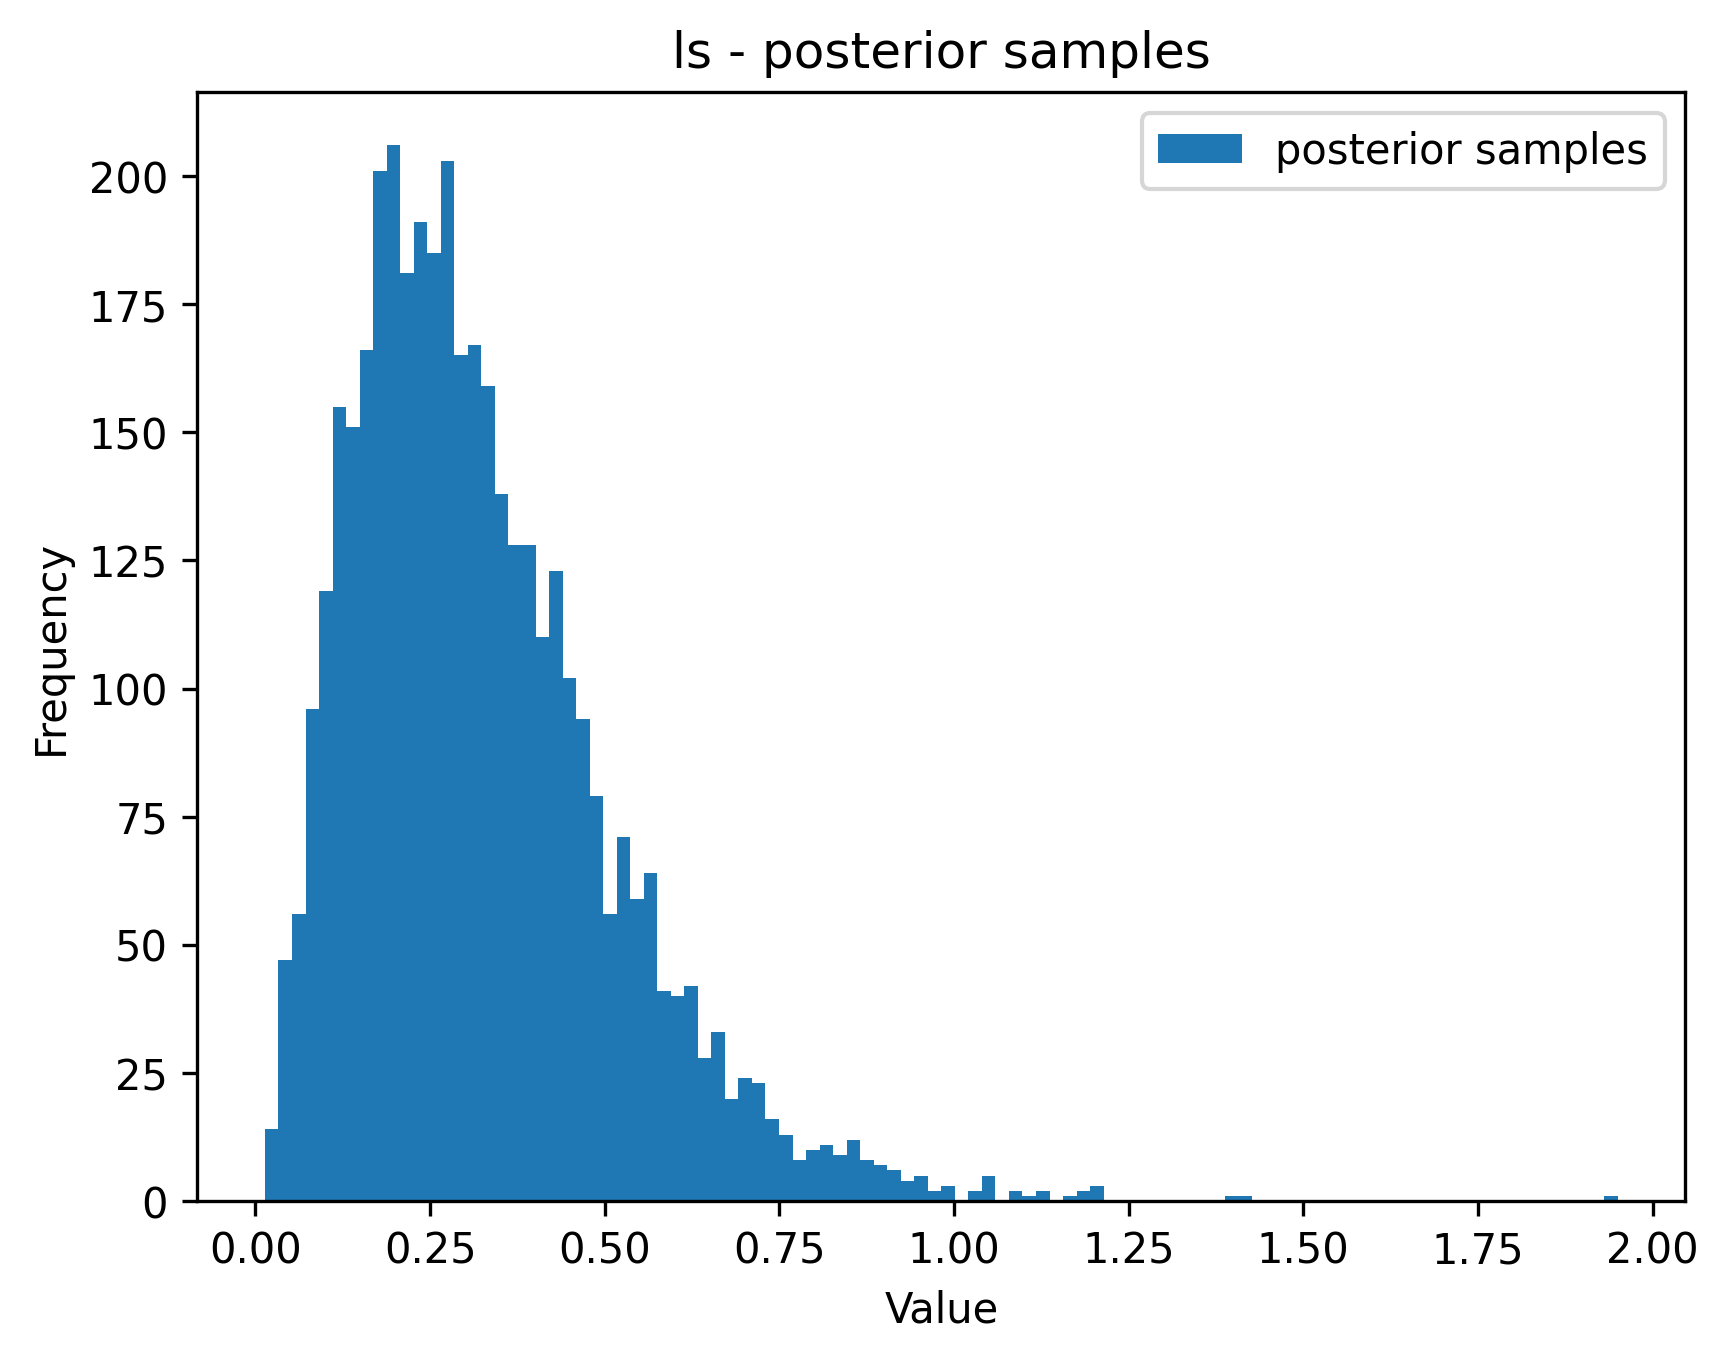

In [66]:
ls_samps = prev_samples['kernel_length']
plt.hist(ls_samps, label = 'posterior samples', bins=100)
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.title('ls - posterior samples')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_ls_posterior_hist.pdf')

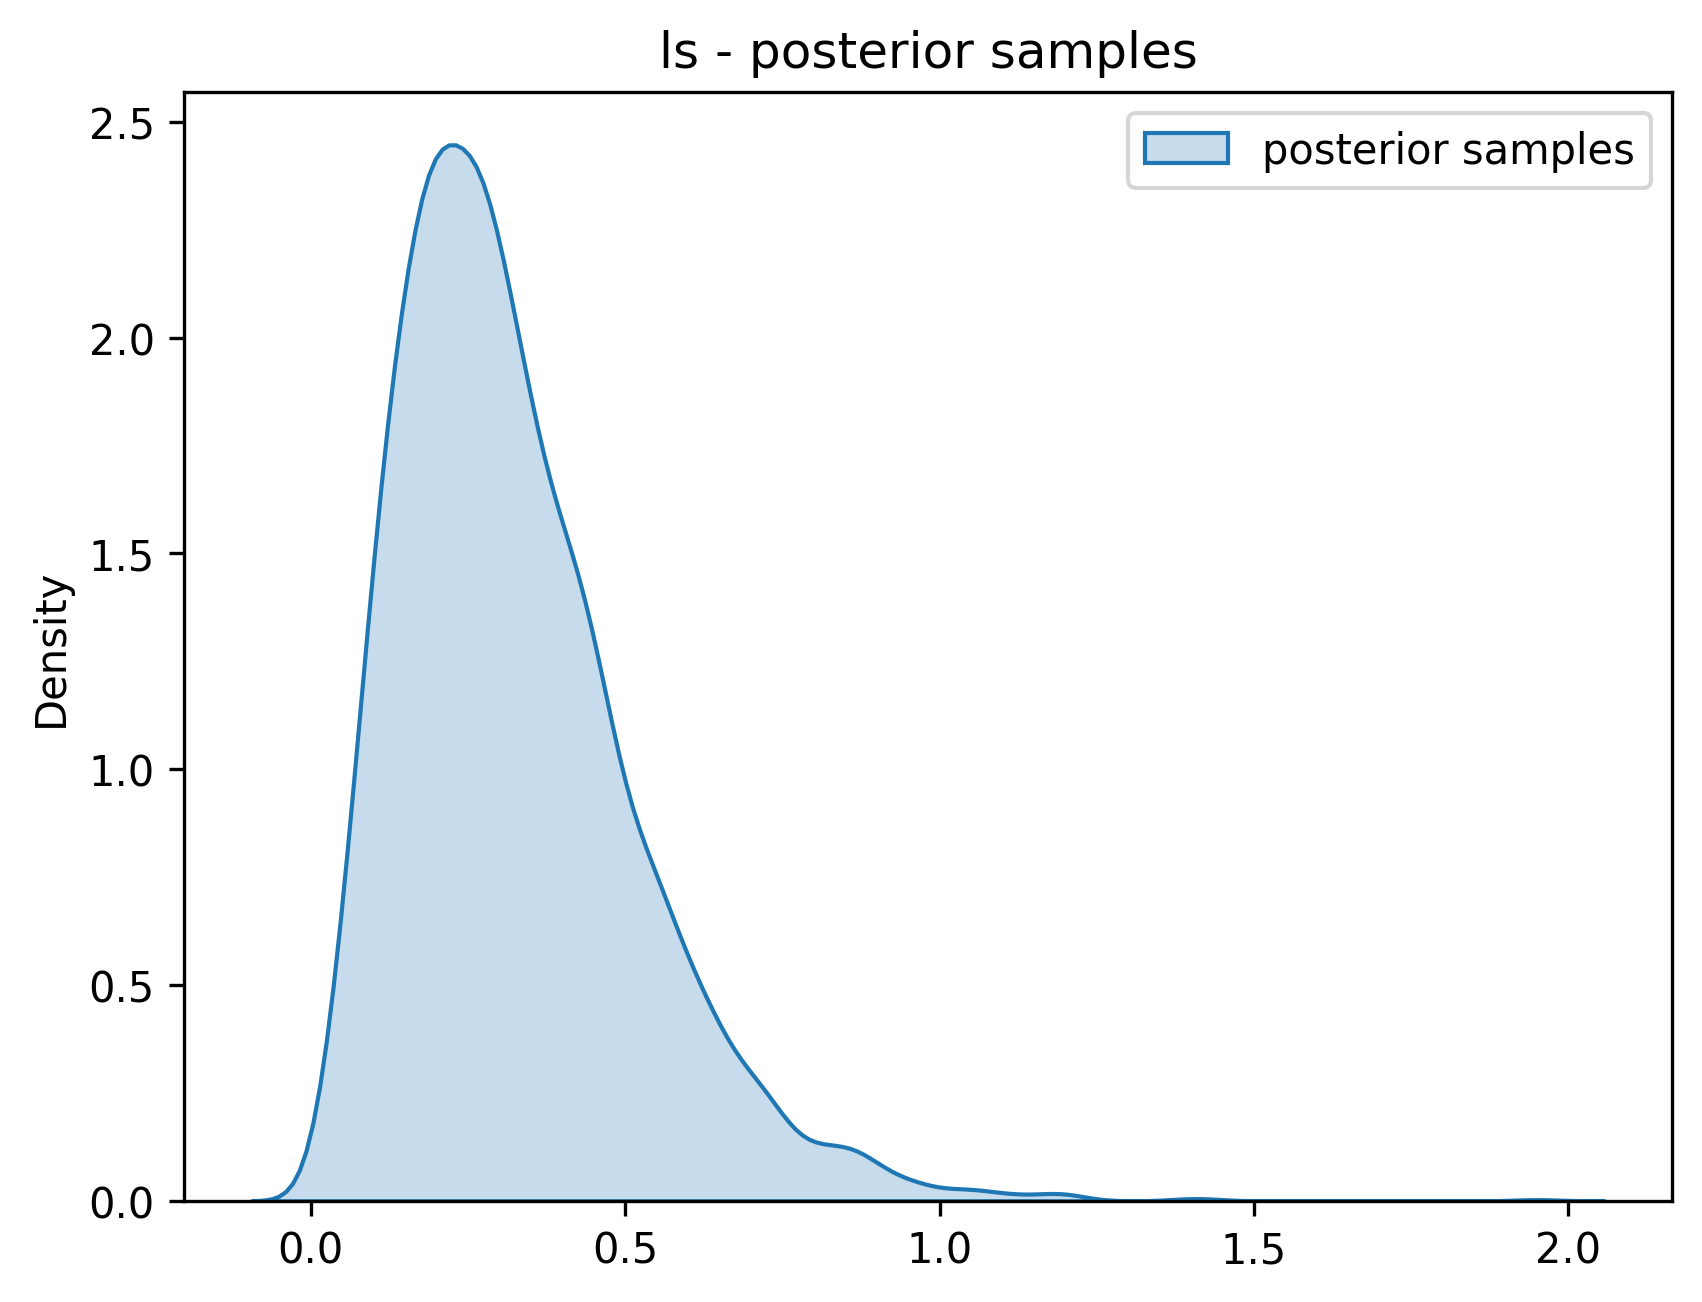

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ls_samps is defined as your list of samples
ls_samps = prev_samples['kernel_length']

# Create a density plot
sns.kdeplot(ls_samps, label='posterior samples', fill=True)

# Optionally, add a vertical line for the true length scale if needed
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.title('ls - posterior samples')
plt.legend()

# Show the plot
plt.show()


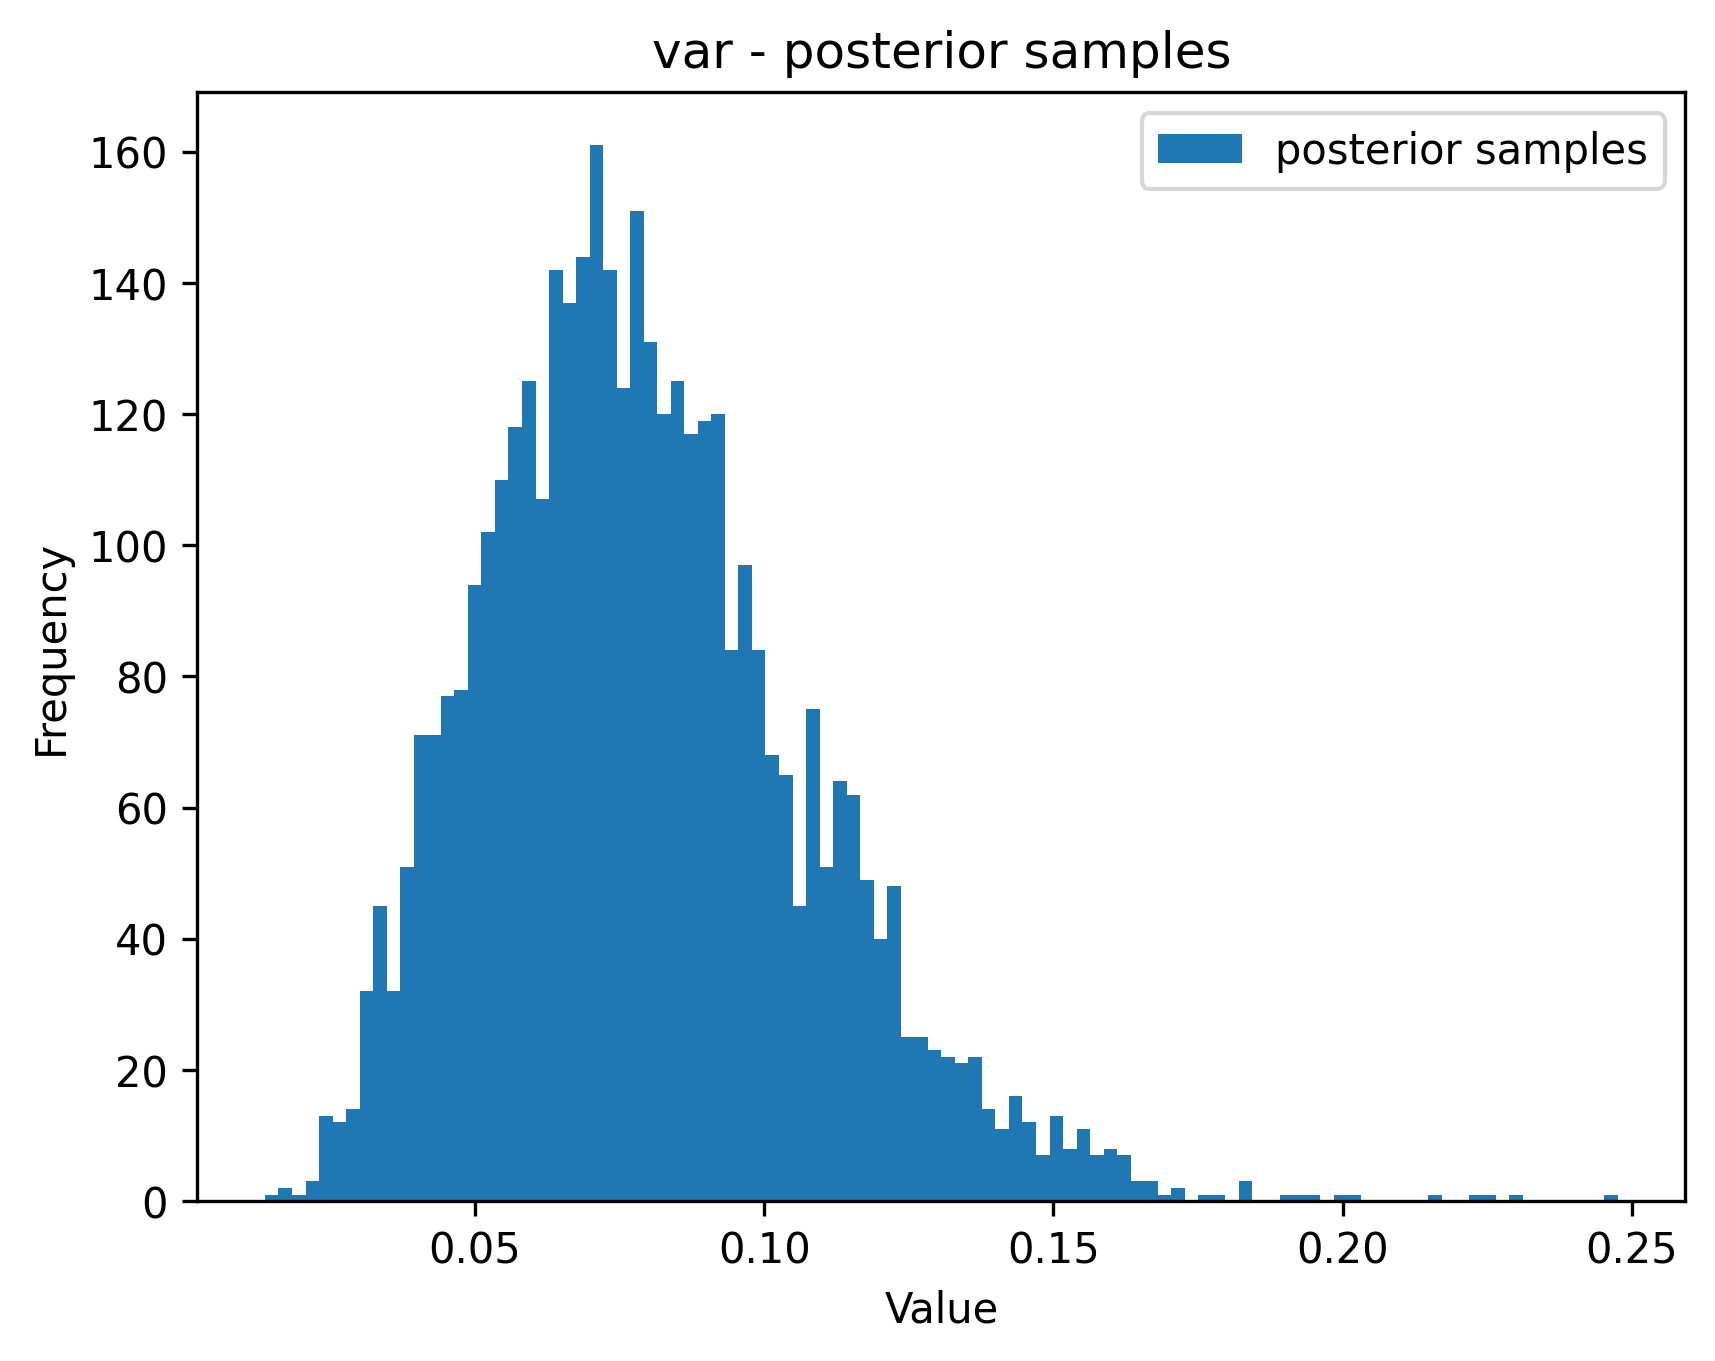

In [68]:
var_samps = prev_samples['kernel_var']
plt.hist(var_samps, label = 'posterior samples', bins=100)
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.title('var - posterior samples')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_var_posterior_hist.pdf')

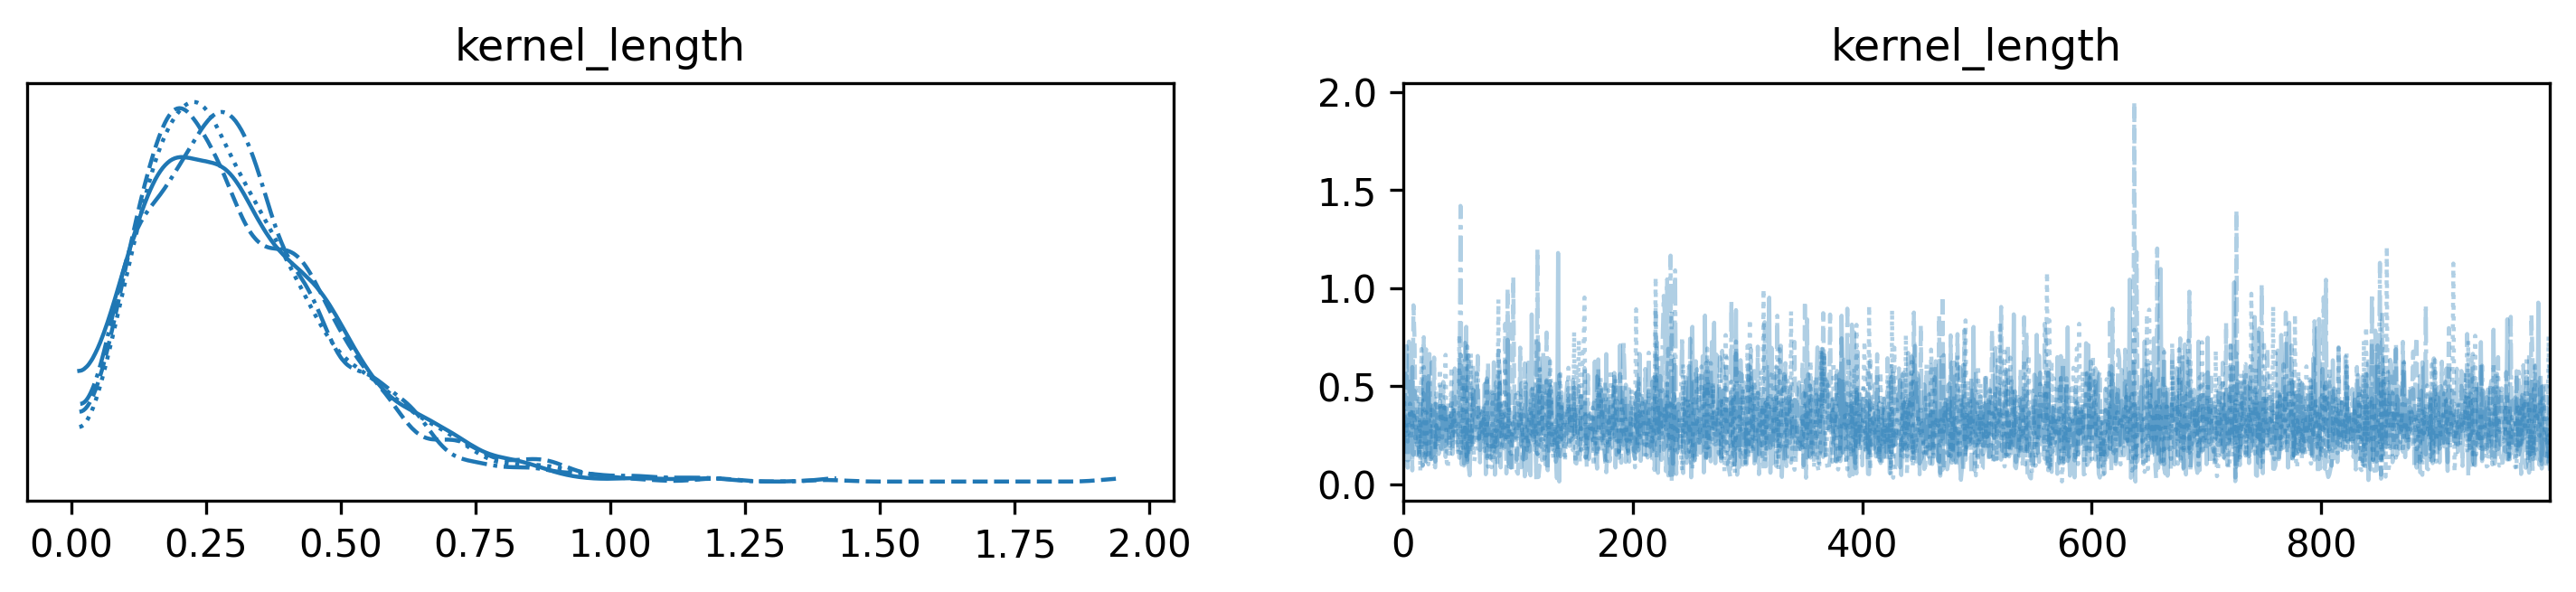

In [69]:
import arviz as az
az_data = az.from_numpyro(mcmc_vae)
az.plot_trace(az_data, var_names=('kernel_length'), filter_vars="like")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_ls_posterior_trace.pdf')

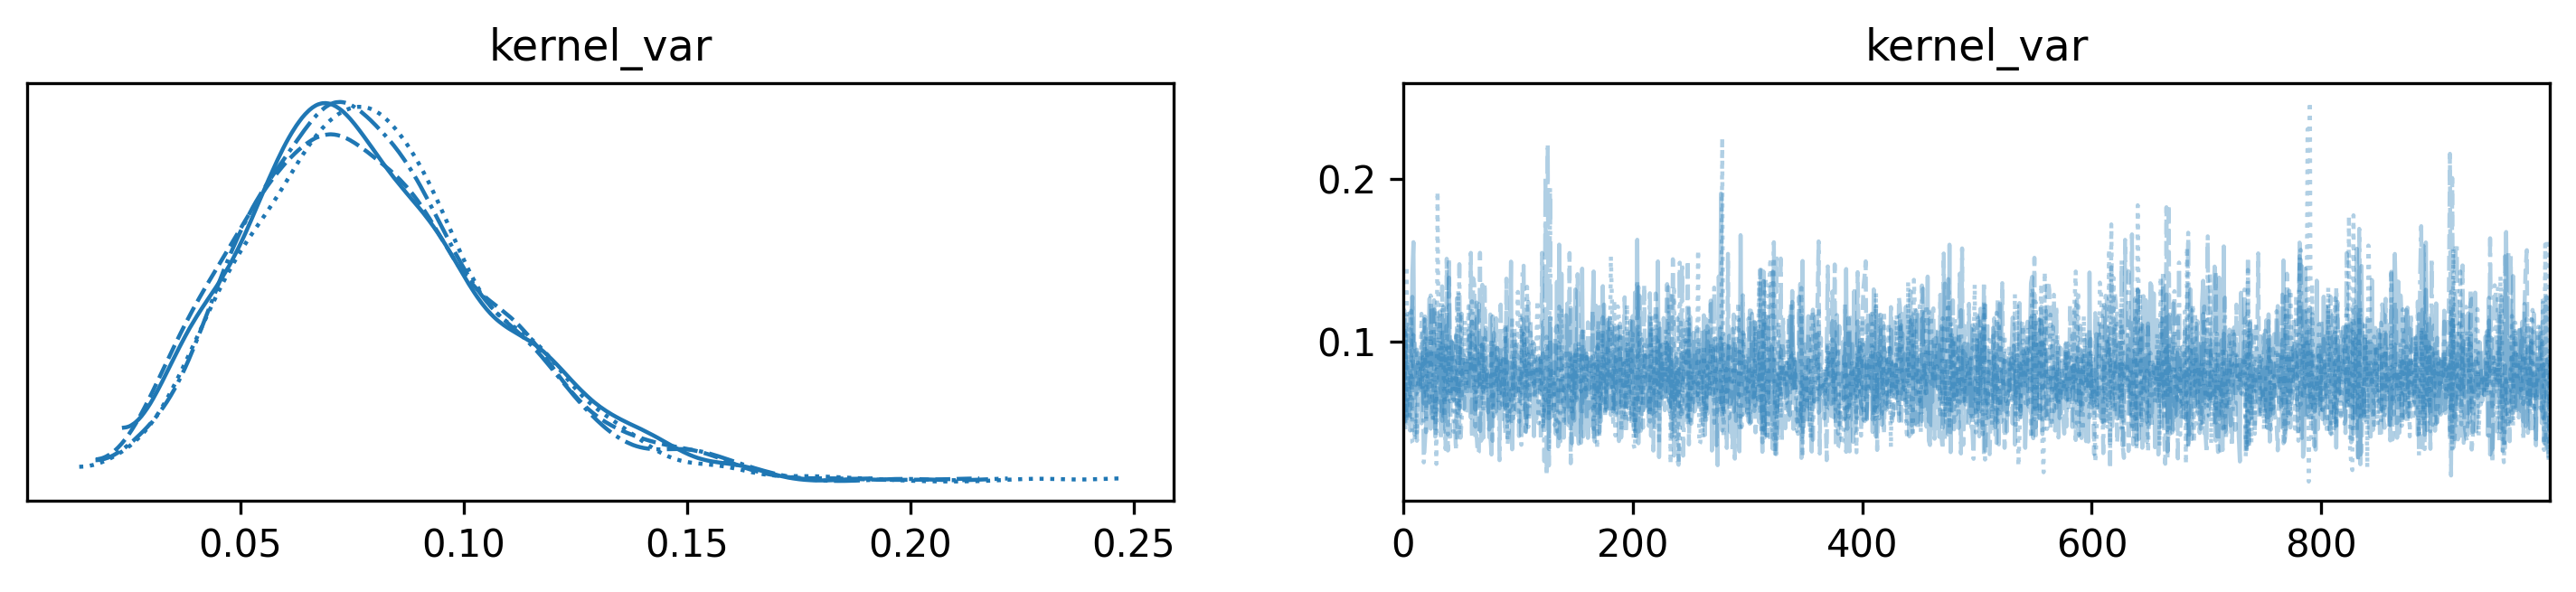

In [70]:
az.plot_trace(az_data, var_names=('kernel_var'), filter_vars="like")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_var_posterior_trace.pdf')

In [71]:
# posterior predictive - 1
prev_posterior_predictive_vae = Predictive(prev_model_vae_aggr, prev_samples)(random.PRNGKey(1), args)

theta_samps_vae_aggr = prev_posterior_predictive_vae['theta']
theta_mean_vae_aggr = theta_samps_vae_aggr.mean(axis=0)
# transpose
theta_mean_vae_aggr = theta_mean_vae_aggr.transpose()
bci_vae_aggr_025 = np.quantile(theta_samps_vae_aggr, 0.025, axis=0)
bci_vae_aggr_975 = np.quantile(theta_samps_vae_aggr, 0.975, axis=0)

s['theta_vae_aggr'] = theta_mean_vae_aggr

theta_observed = s['estimate']
theta_estimated_vae_aggr = s['theta_vae_aggr']

_max = np.max([theta_observed, theta_estimated_vae_aggr])
_min = np.min([theta_observed, theta_estimated_vae_aggr])

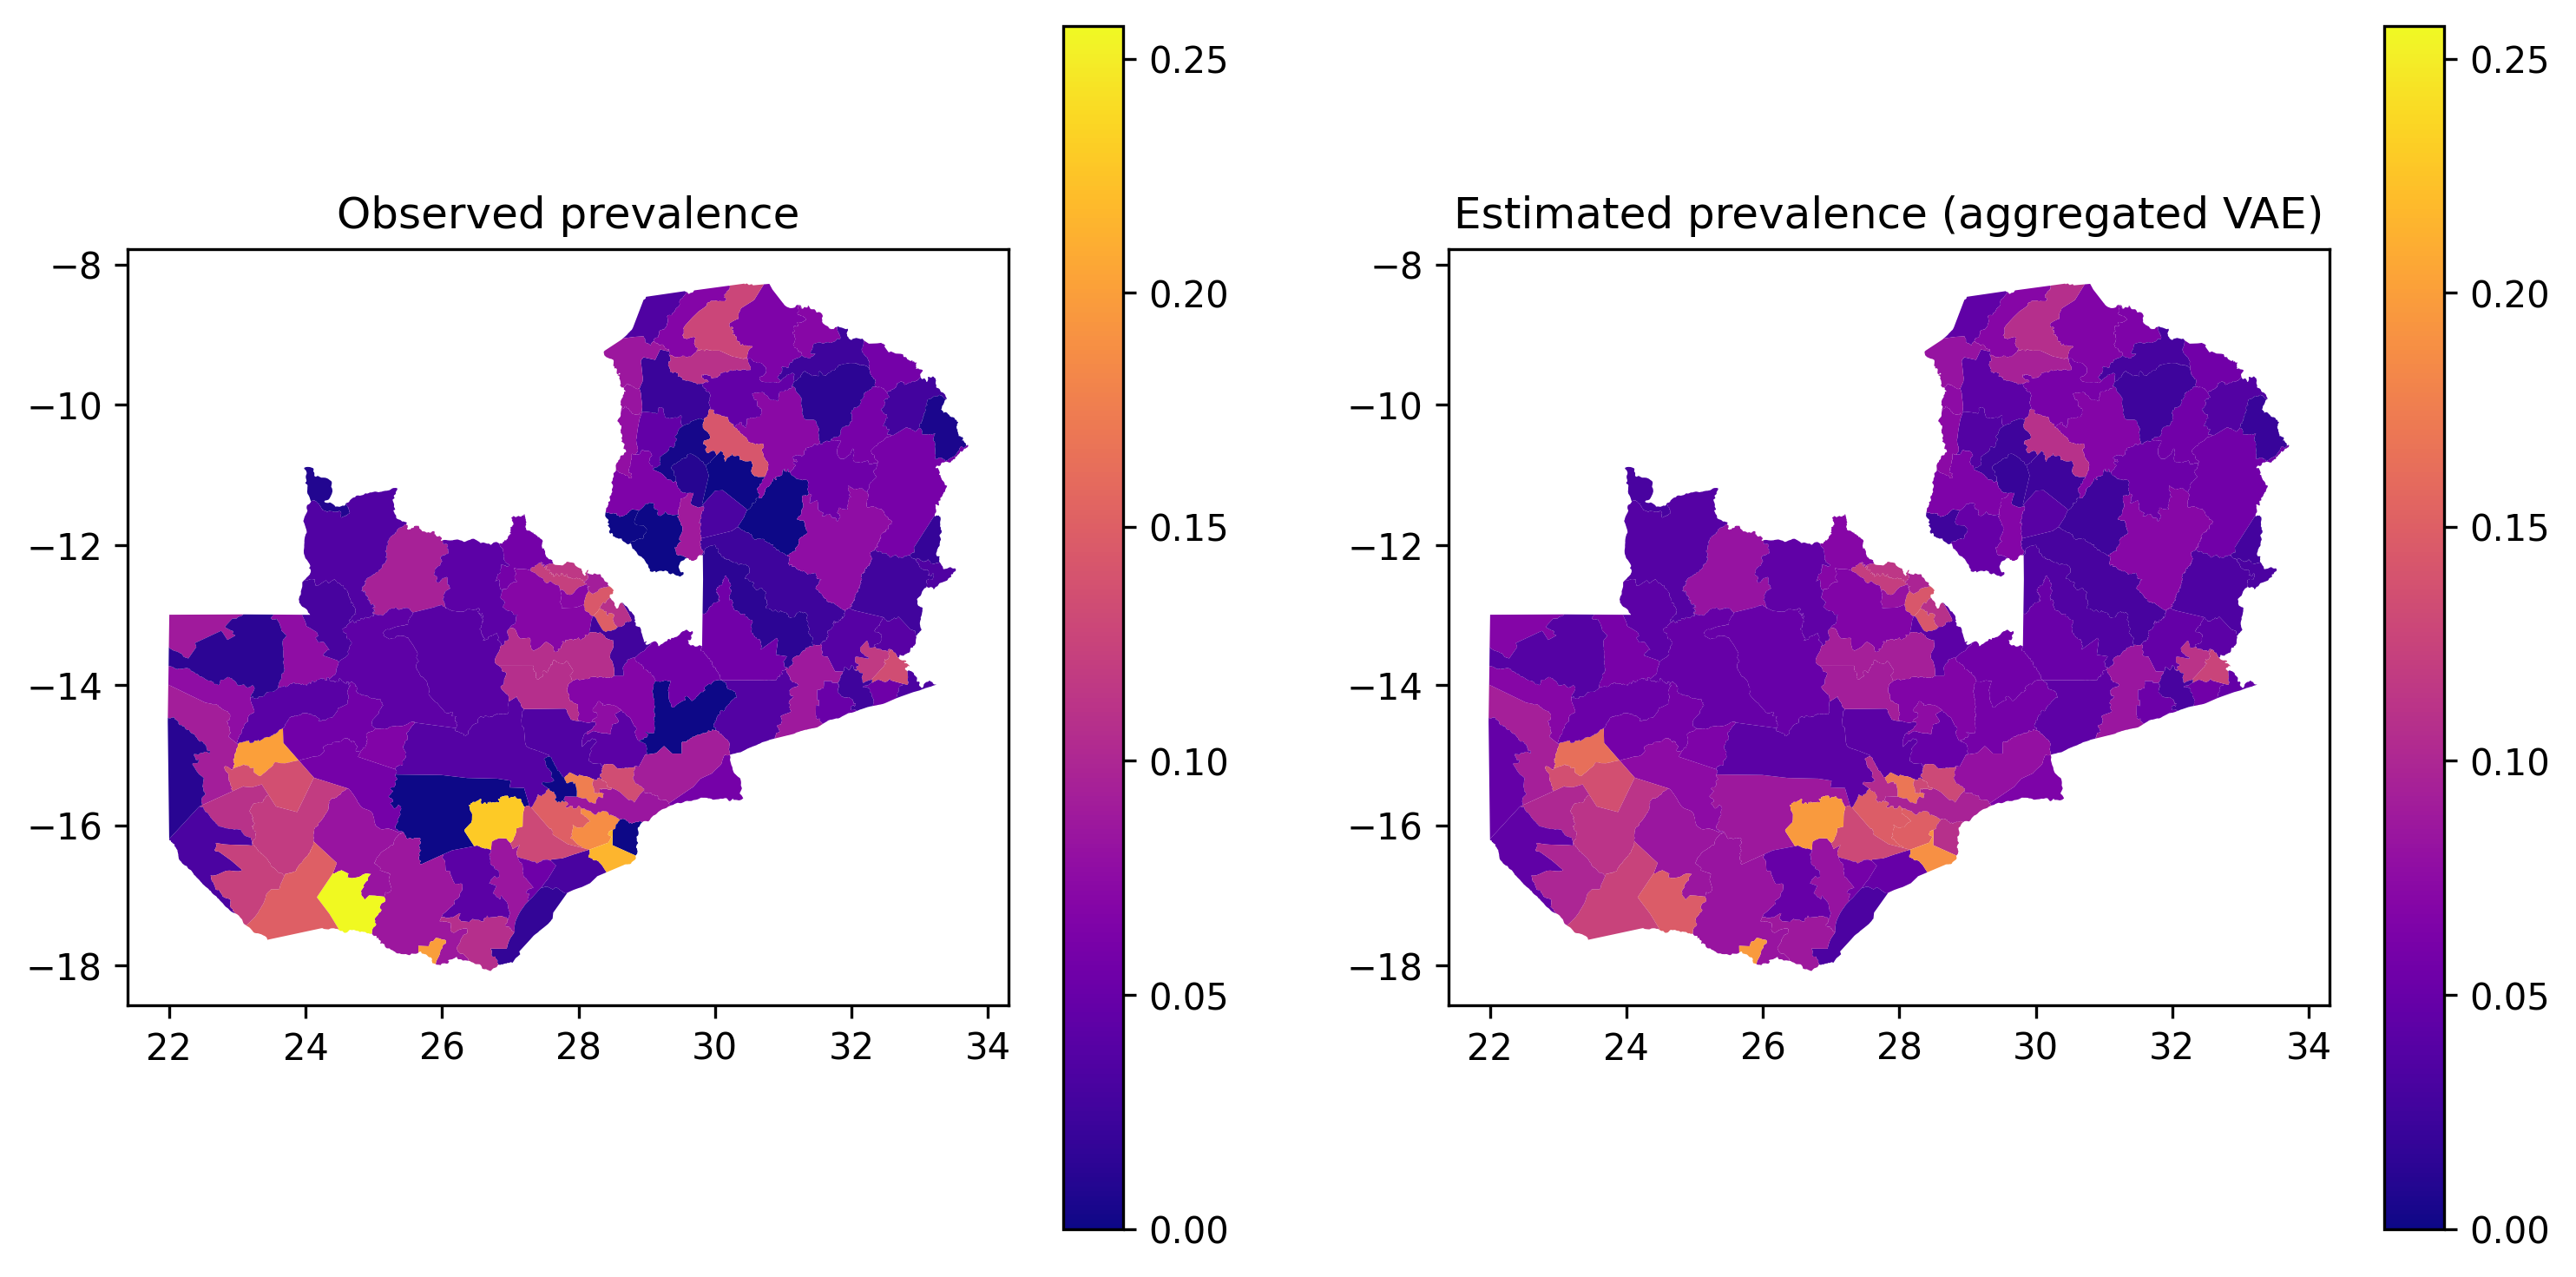

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# s[n_old:(n_old + n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
# s[n_old:(n_old + n_new)].plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

ax[0].set_title('Observed prevalence')
ax[1].set_title('Estimated prevalence (aggregated VAE)')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_prev_results.pdf')

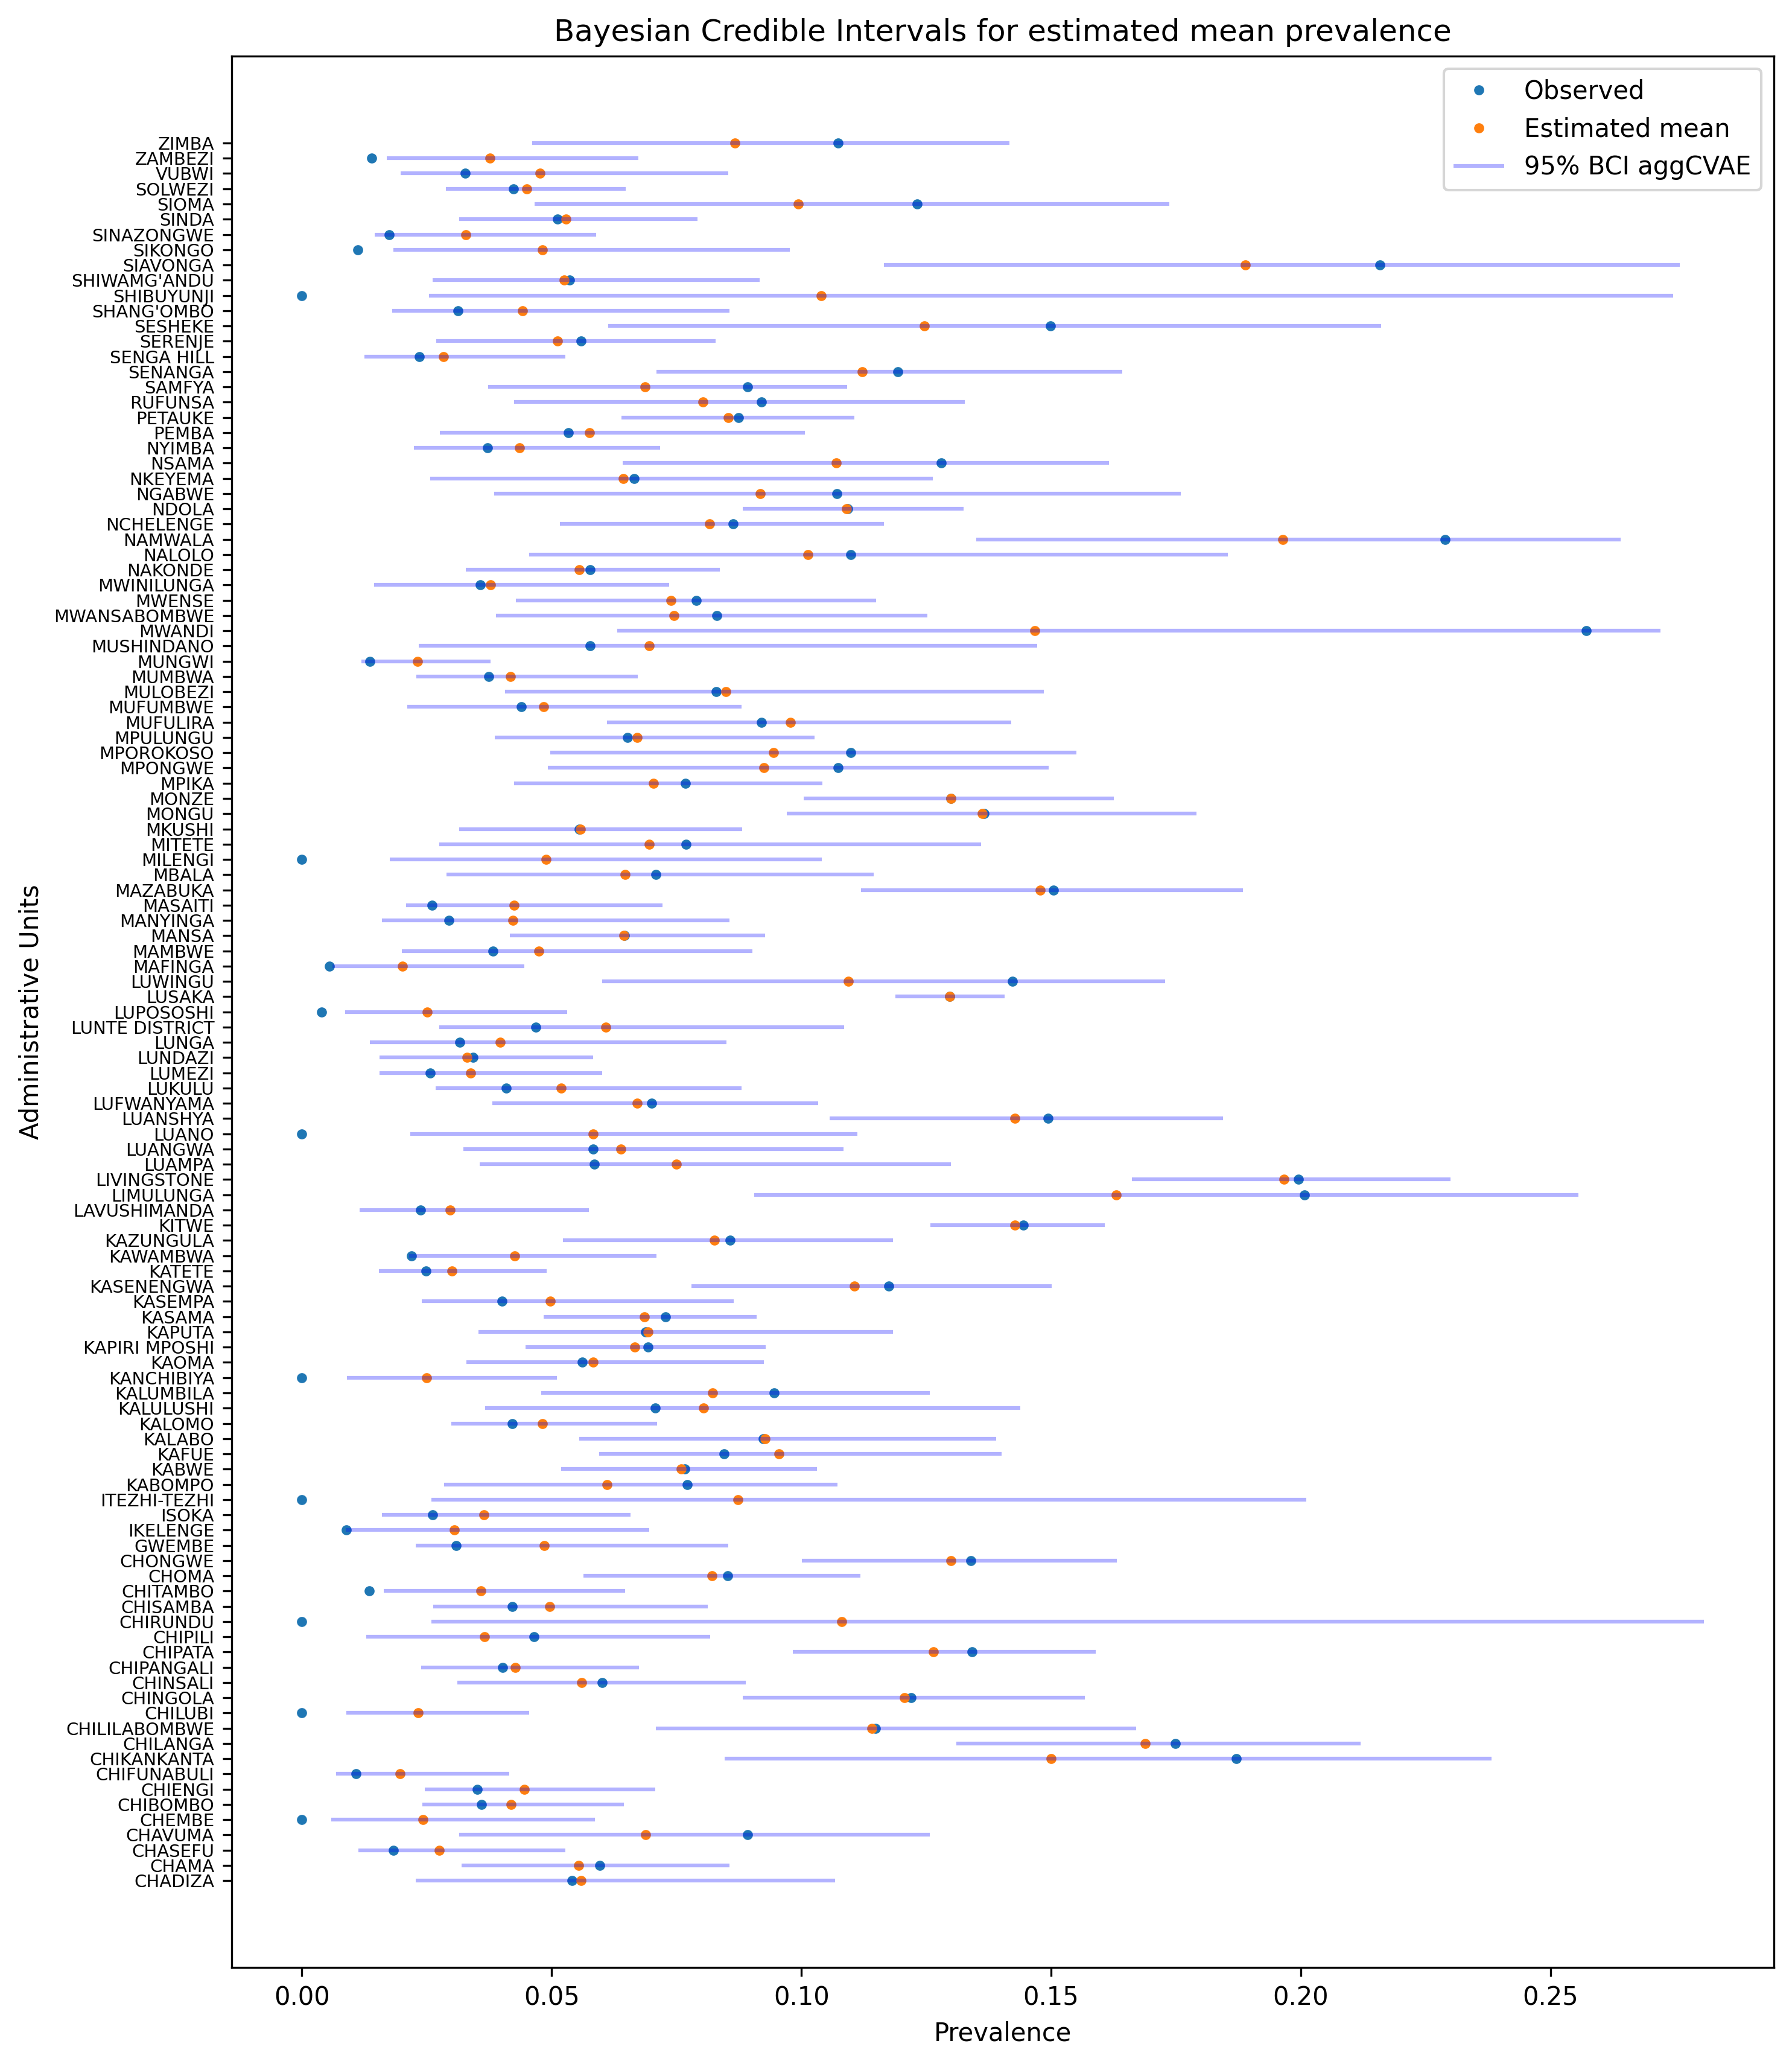

In [73]:
# BCI intervals 

x = np.arange(0, s.shape[0], 1)

# Sort values for plotting by x axis
idx = jnp.argsort(x)
x_axis = s['area']


# Calculate reasonable figure height based on the number of administrative units
fig_height = max(len(x_axis) * 0.1, 8)  # Adjust 0.4 as needed to fit the labels comfortably


# Plot with flipped axes
plt.figure(figsize=(10, fig_height))  # Increase the height of the figure
plt.plot(s["estimate"], x_axis, ".", label="Observed")
plt.plot(theta_mean_vae_aggr, x_axis, ".", label="Estimated mean") 
plt.hlines(x_axis, xmin=bci_vae_aggr_025, xmax=bci_vae_aggr_975, colors="blue", alpha=0.3, label="95% BCI aggCVAE")  # Flipped axes           # Flipped axes
plt.legend()
plt.xlabel('Prevalence')
plt.ylabel('Administrative Units')
plt.title(f'Bayesian Credible Intervals for estimated mean prevalence')

# Adjust y-axis ticks and label spacing
plt.yticks(np.arange(len(x_axis)), x_axis, fontsize=7)  # Customize fontsize and spacing

# Save plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_BCI_intervals_estimated_prev.pdf')
plt.show()

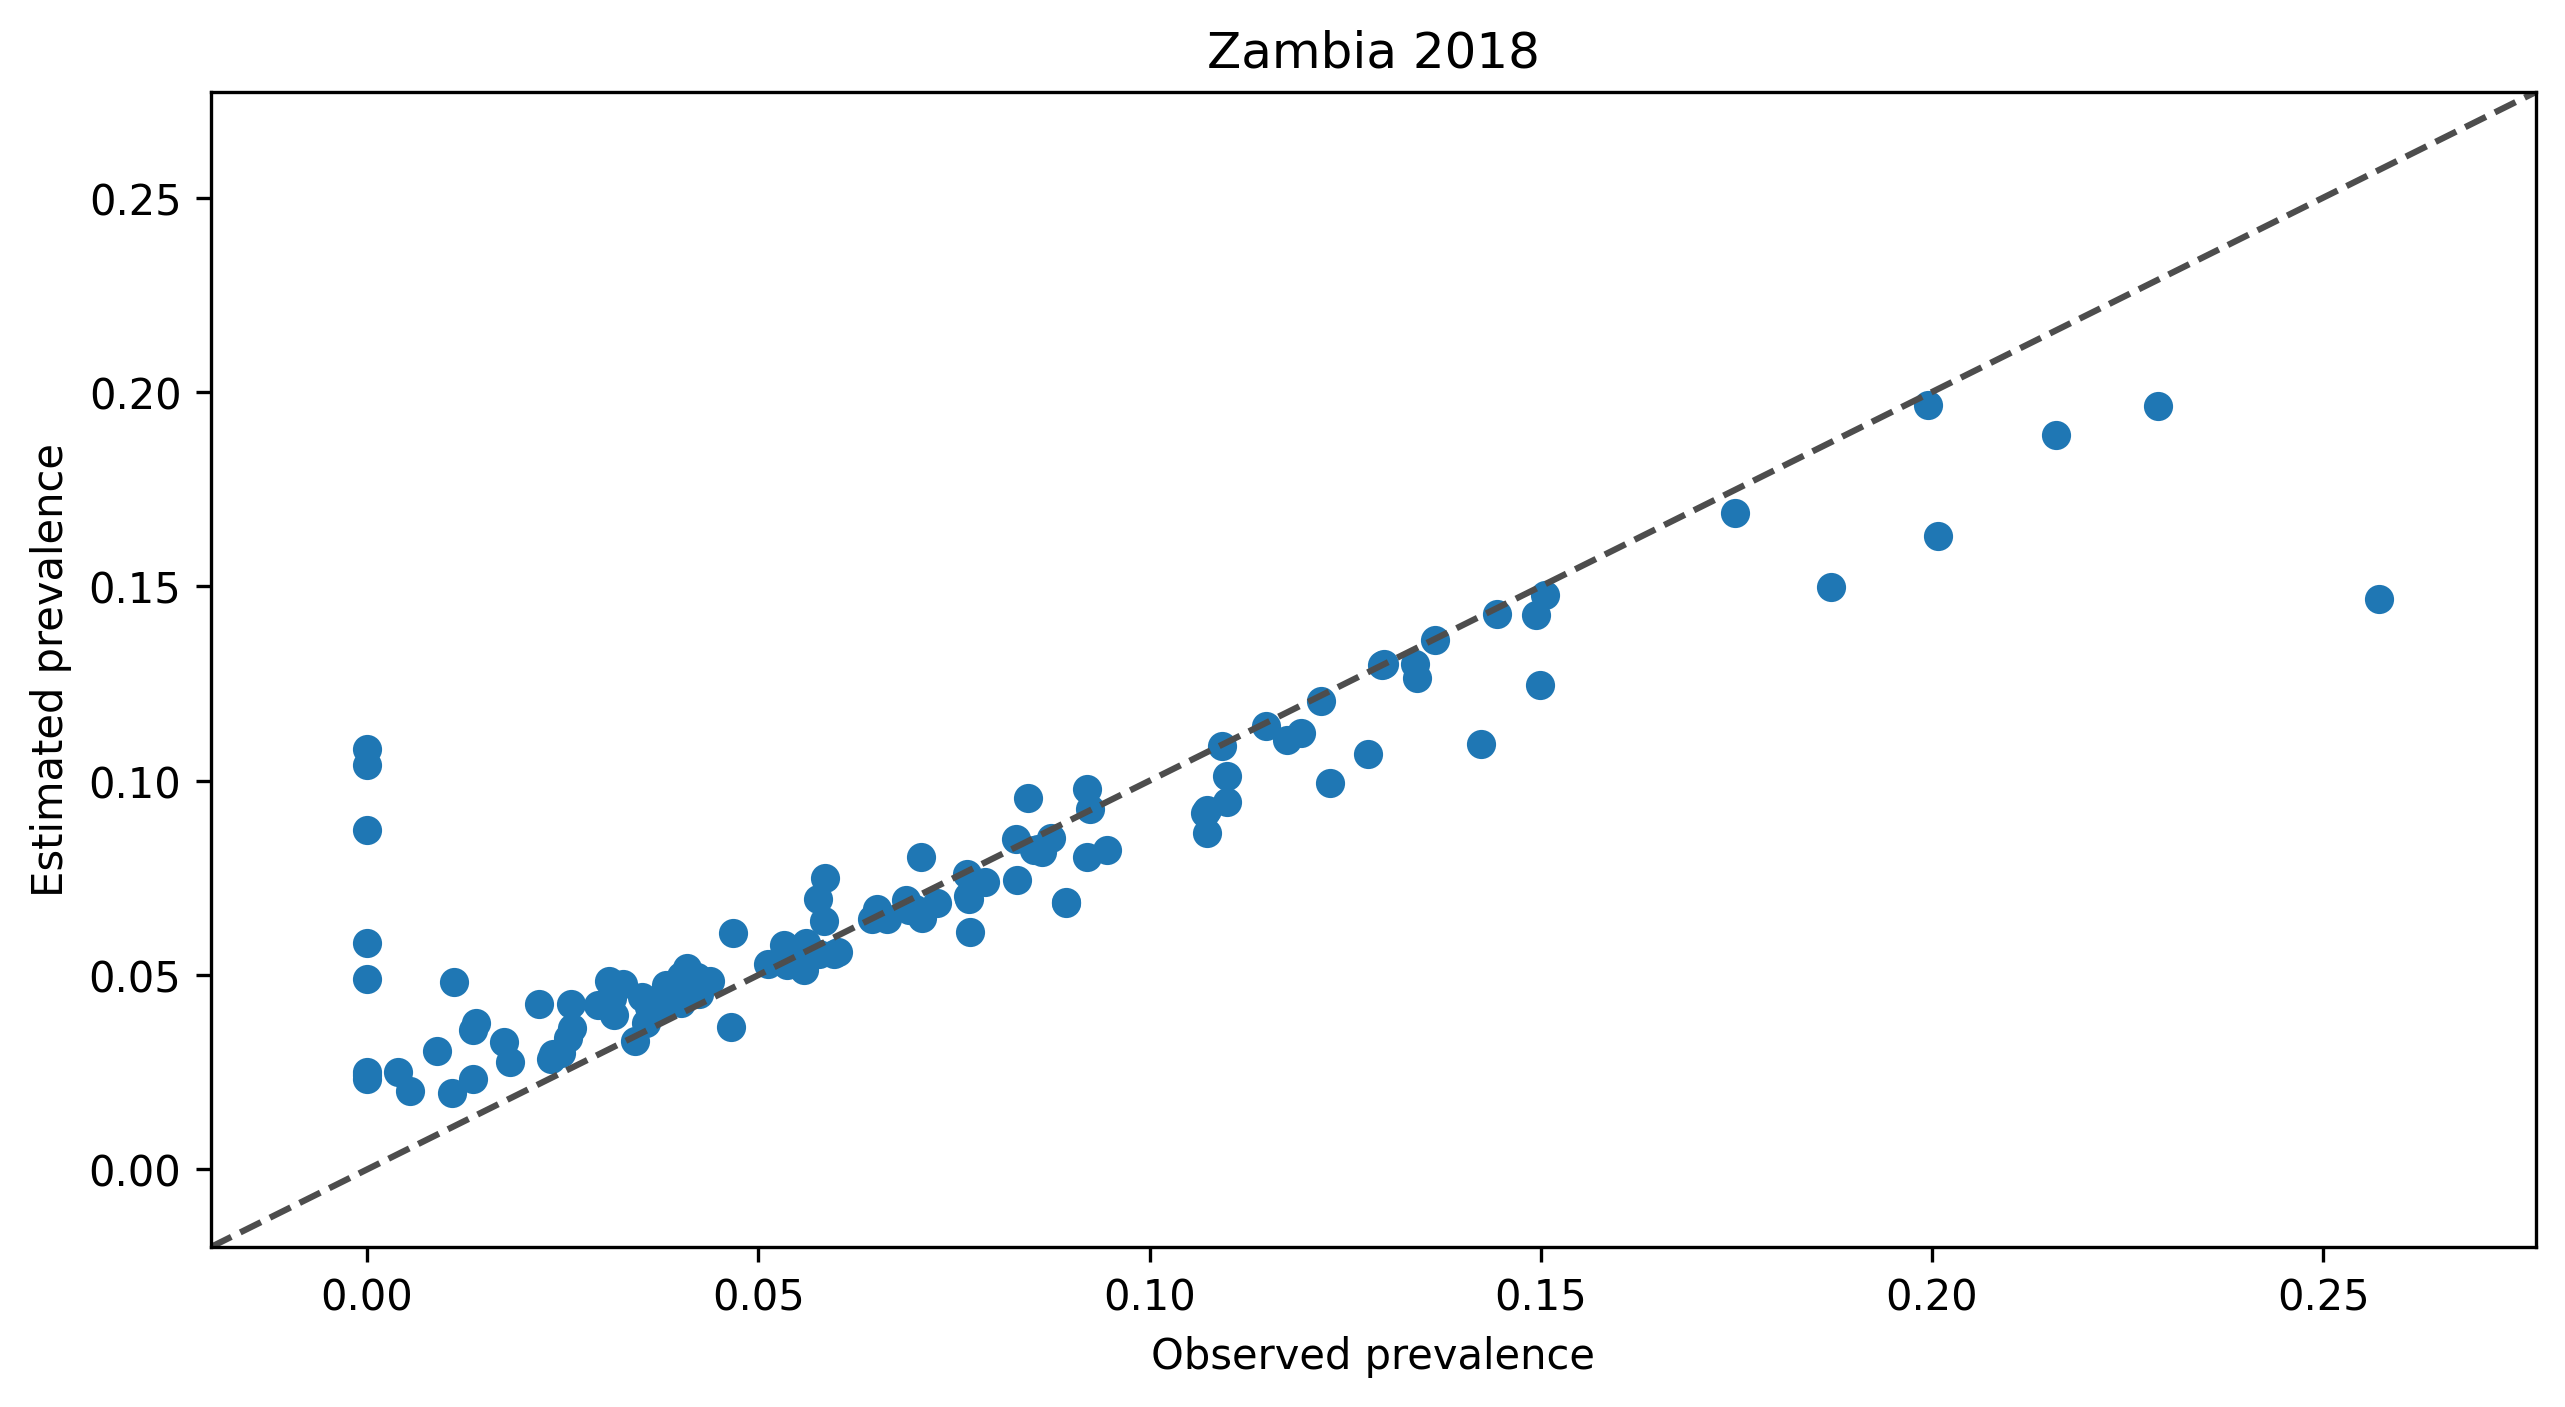

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.scatter(s.estimate, s.theta_vae_aggr)
ax.set_ylim(_min-0.02, _max+0.02)
ax.set_xlim(_min-0.02, _max+0.02)
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.set_xlabel("Observed prevalence")
ax.set_ylabel("Estimated prevalence")
ax.set_title("Zambia 2018")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_prev_results_scatterplot.pdf')

In [75]:
# Example observations and predictions
observations = s.estimate
predictions = s.theta_vae_aggr

# Pearson correlation coefficient
pearson_corr, _ = pearsonr(observations, predictions)
print(f'Pearson correlation coefficient: {pearson_corr:.4f}')

# Spearman correlation coefficient
spearman_corr, _ = spearmanr(observations, predictions)
print(f'Spearman correlation coefficient: {spearman_corr:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(observations, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observations, predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Save results to a text file
with open(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_prev_metrics.txt', 'w') as file:
    file.write(f'Pearson correlation coefficient: {pearson_corr:.4f}\n')
    file.write(f'Spearman correlation coefficient: {spearman_corr:.4f}\n')
    file.write(f'Root Mean Squared Error (RMSE): {rmse:.4f}\n')
    file.write(f'Mean Absolute Error (MAE): {mae:.4f}\n')

# Generate LaTeX table
latex_table = f"""
\\documentclass{{article}}
\\usepackage{{booktabs}}

\\begin{{document}}

\\begin{{table}}[h!]
\\centering
\\begin{{tabular}}{{ll}}
\\toprule
Metric & Value \\\\
\\midrule
Pearson correlation coefficient & {pearson_corr:.4f} \\\\
Spearman correlation coefficient & {spearman_corr:.4f} \\\\
Root Mean Squared Error (RMSE) & {rmse:.4f} \\\\
Mean Absolute Error (MAE) & {mae:.4f} \\\\
\\bottomrule
\\end{{tabular}}
\\caption{{Performance Metrics}}
\\label{{tab:metrics}}
\\end{{table}}

\\end{{document}}
"""

latex_file = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_latex_metrics.tex'
# Save LaTeX table to a .tex file
with open(latex_file, 'w') as file:
    file.write(latex_table)

    
# Save metrics to a pickle file
pickle_file = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_prev_metrics.pkl'
metrics = {
    'pearson_corr': pearson_corr,
    'spearman_corr': spearman_corr,
    'rmse': rmse,
    'mae': mae
}
with open(pickle_file, 'wb') as file:
    pickle.dump(metrics, file)

# Load and verify the LaTeX table
with open(latex_file, 'r') as file:
    latex_data = file.read()
    print("\nLoaded from LaTeX file:")
    print(latex_data)

# Load and verify the pickle file results
with open(pickle_file, 'rb') as file:
    loaded_metrics = pickle.load(file)
    print("\nLoaded from pickle file:")
    print(loaded_metrics)

# Check if loaded metrics match the original metrics
assert np.isclose(loaded_metrics['pearson_corr'], pearson_corr), "Pearson correlation coefficient does not match."
assert np.isclose(loaded_metrics['spearman_corr'], spearman_corr), "Spearman correlation coefficient does not match."
assert np.isclose(loaded_metrics['rmse'], rmse), "RMSE does not match."
assert np.isclose(loaded_metrics['mae'], mae), "MAE does not match."

print("All metrics loaded correctly from the pickle file.")


Pearson correlation coefficient: 0.9080
Spearman correlation coefficient: 0.8757
Root Mean Squared Error (RMSE): 0.0243
Mean Absolute Error (MAE): 0.0140

Loaded from LaTeX file:

\documentclass{article}
\usepackage{booktabs}

\begin{document}

\begin{table}[h!]
\centering
\begin{tabular}{ll}
\toprule
Metric & Value \\
\midrule
Pearson correlation coefficient & 0.9080 \\
Spearman correlation coefficient & 0.8757 \\
Root Mean Squared Error (RMSE) & 0.0243 \\
Mean Absolute Error (MAE) & 0.0140 \\
\bottomrule
\end{tabular}
\caption{Performance Metrics}
\label{tab:metrics}
\end{table}

\end{document}


Loaded from pickle file:
{'pearson_corr': 0.9079758503218015, 'spearman_corr': 0.8756876111710966, 'rmse': 0.024315465476758755, 'mae': 0.014000752922254625}
All metrics loaded correctly from the pickle file.


In [76]:
def prev_model_gp_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_old = args["M_old"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", dist.InverseGamma(3,3))
    var = numpyro.sample("kernel_var", dist.HalfNormal(0.05))
    k = gp_kernel(x, x, var, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f))
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    gp_aggr = numpyro.deterministic('gp_aggr', jnp.concatenate([gp_aggr_old, gp_aggr_new]))

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))

    # linear predictor
    lp = b0 + gp_aggr
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [ ]:
# Load
#with open('MCMCs/prev_model_gp_aggr_joint_500iter_lsIG3_3', 'rb') as file:
#    mcmc_gp_aggr = pickle.load(file)

#prev_samples_aggr = mcmc_gp_aggr.get_samples()
#mcmc_gp_aggr.print_summary(exclude_deterministic=False)

In [ ]:
# posterior predictive
prev_posterior_predictive = Predictive(prev_model_gp_aggr, prev_samples_aggr)(random.PRNGKey(1), args)

theta_samps_gp = prev_posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = np.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = np.quantile(theta_samps_gp, 0.75, axis=0)

s['theta_gp'] = theta_mean_gp
theta_estimated_gp = s['theta_gp']

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(s[0:n_old].theta_gp, s[0:n_old].theta_vae_aggr)
ax[0].set_ylim(_min-0.02, _max+0.02)
ax[0].set_xlim(_min-0.02, _max+0.02)
ax[0].axline((1, 1), slope=1, ls="--", c=".3")
ax[0].set_xlabel("estimated prev (aggGP)")
ax[0].set_ylabel("estimated prev (aggVAE)")
ax[0].set_title("before 2010")

ax[1].scatter(s[n_old:(n_old + n_new)].theta_gp, s[n_old:(n_old + n_new)].theta_vae_aggr)
ax[1].set_ylim(_min-0.02, _max+0.02)
ax[1].set_xlim(_min-0.02, _max+0.02)
ax[1].axline((1, 1), slope=1, ls="--", c=".3")
ax[1].set_xlabel("estimated prev (aggGP)")
ax[1].set_ylabel("estimated prev (aggVAE)")
ax[1].set_title("after 2010")

In [ ]:
# 1
_max = np.max([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])
_min = np.min([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Before: Observed prev')
ax[1].set_title( 'Before: Estimated prev (aggGP)')
ax[2].set_title( 'Before: Estimated prev (aggVAE)')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[n_old:(n_old+n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'After: Observed prev')
ax[1].set_title( 'After: Estimated prev (aggGP)')
ax[2].set_title( 'After: Estimated prev (aggVAE)')